In [1]:

import time
import emcee
import numpy
import pandas
import astropy

from scipy.stats import norm
from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler, SplineInterpolatedResampler

from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve
from astropy import units as u
from astroquery.sdss import SDSS
from astropy.io.votable import parse
from astropy.coordinates import SkyCoord
from astropy import coordinates as coords
from astropy.io.votable import parse_single_table

from scipy.ndimage import gaussian_filter

from astropy.io import fits # From https://astro-330.github.io/Lab5/Lab5_solutions.html


import matplotlib.pyplot as plt
%matplotlib inline

# Shin et al. 2019 https://iopscience.iop.org/article/10.3847/1538-4357/ab05da
# Fe template http://www.ioa.s.u-tokyo.ac.jp/~kkawara/quasars/

# Introduction

This notebook is my attempt in reproducing fig. of [K. Hryniewicz et al. 2010](https://academic.oup.com/mnras/article/404/4/2028/1087097). In this notebook I use SDSS python library to fetch the quasar of interest online, use Astropy library to do some preprocessing including binning, use EMCEE and Pyro libraries to do the parameter estimation steps using Haamilotnian Monte Carlo method. Overall, it was a good experiance and I managed to get some similar results to fig. 1 of [K. Hryniewicz et al. 2010](https://academic.oup.com/mnras/article/404/4/2028/1087097). However, my results are some early results and further work is needed (see the conclusion part at the end of this notebook).

### Vestergard Template

In [2]:
fe_ves     = pandas.read_csv("fe_ves.txt", sep=' ')
fe_ves_nan = pandas.read_csv("fe_ves.txt", sep=' ', index_col = False)

fe_ves     = fe_ves.drop(columns = "lambda_wave")

fe_ves_nan         = fe_ves_nan.drop(columns = "flux")
fe_ves_nan["flux"] = fe_ves["flux"].values
fe2_3_ves  = fe_ves_nan
fe2_3_ves

/tmp/ipykernel_58584/3065898832.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  fe_ves_nan = pandas.read_csv("fe_ves.txt", sep=' ', index_col = False)


,lambda_wave,flux
0,1074.987000,0.0
1,1075.468966,0.0
2,1075.950931,0.0
3,1076.432897,0.0
4,1076.914862,0.0
...,...,...
4176,3087.675346,0.0
4177,3088.157311,0.0
4178,3088.639277,0.0
4179,3089.121242,0.0


### Tsuzuki Template

In [3]:
fe_uv = pandas.read_csv("fe_UV_tsuzuki_2006", sep=',')
fe_uv

,wave_length,flux_density
0,2200.0200,0.000000e+00
1,2200.5100,3.238911e-16
2,2200.9900,5.511096e-16
3,2201.4800,1.438183e-15
4,2201.9600,2.127195e-16
...,...,...
2703,3497.8999,4.027763e-15
2704,3498.3501,3.271061e-15
2705,3498.8000,3.148871e-15
2706,3499.2400,2.831105e-15


In [4]:
dr16Q = fits.open("DR16Q_v4.fits")
dr16Q.info()

Filename: DR16Q_v4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  CATALOG       1 BinTableHDU    375   750414R x 183C   [18A, D, D, J, J, I, 6A, 6A, I, D, I, D, I, I, I, K, D, I, I, D, I, D, I, D, D, I, D, 12A, D, J, 19A, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, D, K, D, E, 5D, 5D, 5D, E, D, D, D, D, D, D, D, D, K, K, K, K, K, K, J, J, J, 74J, 74J, 74I, 74I, B, J, 3A, J, J, J, D, D, D, D, 14A, J, D, 5E, 5D, 5E, 5D, 5E, D, D, I, D, D, D, D, I, D, D, D, D, D, D, D, D, E, E, E, E, E, E, E, E, E, I, E, E, E, E, E, E, E, E, E, I, I, D, D, D, D, D, D, J, D, D, D, J, D, D, D, J, D, 21A, D, D, E, E, D, K, D, D, E, E, E, E, E, E, E, D, I, 28A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [5]:
hdu_0 = dr16Q[0]
hdu_1 = dr16Q[1]
hdu_1.header.keys

<bound method Header.keys of XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2290 / length of dimension 1                          
NAXIS2  =               750414 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  183 / number of table fields                         
TTYPE1  = 'SDSS_NAME'                                                           
TFORM1  = '18A     '                                                            
TTYPE2  = 'RA      '                                                            
TFORM2  = 'D       '                                                            

### Using SDSS name

In [90]:
for i in range(len(hdu_1.data)):
    if hdu_1.data[i][0] == "094533.99+100950.1":
        print(i)
        break

### Using PLATE-MJD-FIBER numbers

In [151]:
# 0332-52367-0639
# 6323-56187
for i in range(len(hdu_1.data)):
    if hdu_1.data[i][3] == 5319 and hdu_1.data[i][4] == 55953 and hdu_1.data[i][5] == 744:
        print(i)
        break

265627


### Using SDSS_ID number

In [ ]:
for i in range(len(hdu_1.data)):
    if hdu_1.data[i]["OBJID"] == "373974455765985280":
        print(i)
        break

### Getting the spectrum form SDSS directly

In [91]:
pos = coords.SkyCoord('09h45m33.99s +10d09m50.0s', frame='icrs')

xid = SDSS.query_region(pos, spectro=True)
print(xid)

       ra              dec        ...      specobjid       run2d 
---------------- ---------------- ... ------------------- -------
146.391626434038 10.1639070753707 ... 1469433565103024128      26
146.391626434038 10.1639070753707 ... 5988866213534474240 v5_10_0


/home/nbal@storm.internal/miniconda3/envs/nozhan_test_env_2/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


In [92]:
hspec_J0945_1009 = SDSS.get_spectra(matches=xid)

In [93]:
number = 1
hspec_J0945_1009[number].info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     120   ()      
  1  COADD         1 BinTableHDU     26   4593R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPALL         1 BinTableHDU    488   1R x 236C   [27A, 14A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 7A, 7A, 16A, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 16A, 9A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, J, 6A, 21A, E, 35E, K, 19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5

In [94]:
hspec_J0945_1009[number][2].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4016 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  236 / number of table fields                         
TTYPE1  = 'PROGRAMNAME'                                                         
TFORM1  = '27A     '                                                            
TTYPE2  = 'CHUNK   '                                                            
TFORM2  = '14A     '                                                            
TTYPE3  = 'PLATEQUALITY'    

In [95]:
hspec_J0945_1009[number][1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                 4593 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    8 / number of table fields                         
TTYPE1  = 'flux    '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'loglam  '                                                            
TFORM2  = 'E       '                                                            
TTYPE3  = 'ivar    '        

In [96]:
print(hspec_J0945_1009[number][2].data["PLATE"])
print(hspec_J0945_1009[number][2].data["MJD"])
print(hspec_J0945_1009[number][2].data["FIBERID"])

[5319]
[55953]
[744]


In [97]:
hdu_1.header#.data[265627]

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2290 / length of dimension 1                          
NAXIS2  =               750414 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  183 / number of table fields                         
TTYPE1  = 'SDSS_NAME'                                                           
TFORM1  = '18A     '                                                            
TTYPE2  = 'RA      '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'DEC     '        

### Finding A_V using A_U
See section 3.1 of [Chen Hu et al. 2008](https://iopscience.iop.org/article/10.1086/591838). 

In [98]:
index_number = 265627
hdu_1.data[index_number]["EXTINCTION"]

array([0.09609525, 0.07487676, 0.0517994 , 0.0384925 , 0.02863135],
      dtype=float32)

In [99]:
A_U = 0.09609525
A_v = A_U/1.579
A_v

0.060858296390120324

In [100]:
A_v/3.1

0.01963170851294204

### flux error (with the applied data mask)

In [101]:
flux_error = 1/numpy.sqrt(hspec_J0945_1009[number][1].data["ivar"][hspec_J0945_1009[number][1].data["and_mask"]==0].astype("float32"))
flux_error

/tmp/ipykernel_58584/2343249154.py:1: RuntimeWarning: divide by zero encountered in divide
  flux_error = 1/numpy.sqrt(hspec_J0945_1009[number][1].data["ivar"][hspec_J0945_1009[number][1].data["and_mask"]==0].astype("float32"))


array([6.5866375, 6.652636 , 6.908368 , ..., 4.324231 , 3.6782968,
       3.871175 ], dtype=float32)

We replace the error values that are infinity with the maximum value of error!

In [102]:
inf_mask = numpy.where(flux_error == numpy.inf)[0]
inf_mask

array([3615, 3824, 4104])

In [103]:
flux_removed = numpy.delete(flux_error, inf_mask)

In [104]:
flux_error   = numpy.where(flux_error == numpy.inf, flux_removed.max(), flux_error)# * 10**(-17)

### Redshift, RA, and DEC

In [105]:
obj_red = hspec_J0945_1009[number][2].data["Z"][0]
print(hspec_J0945_1009[number][2].data["RA"][0])
print(hspec_J0945_1009[number][2].data["DEC"][0])
print(hspec_J0945_1009[number][2].data["Z"][0])

146.3916264340383
10.163907075370695
5.13634


### Getting flux and visualising the spectrum of J093514.41+343659.5

In [106]:
h_data   = hspec_J0945_1009[number][1].data
h_flux   = h_data["flux"][hspec_J0945_1009[number][1].data["and_mask"]==0]# * 10**(-17)
h_lambda = 10**h_data["loglam"][hspec_J0945_1009[number][1].data["and_mask"]==0]

# sky_flux = hspec[number][1].data["sky"] * 10**(-17)

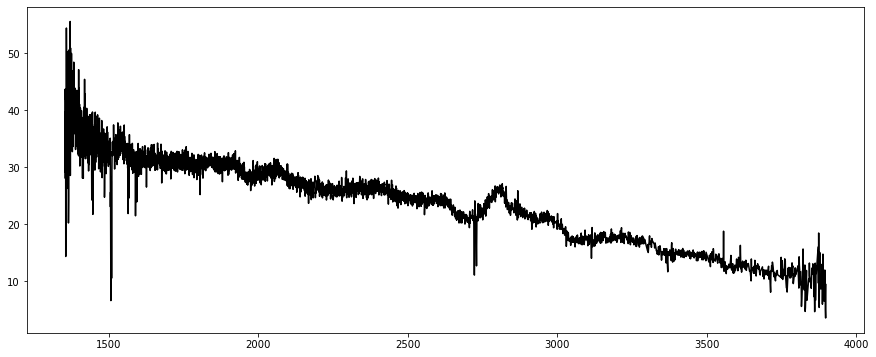

In [107]:
fig, ax = plt.subplots(1, 1, figsize = (15, 6))

plt.plot(h_lambda/(1.66 + 1), h_flux, "k-")

### Luminosity plot (note the unit on the y-axis)

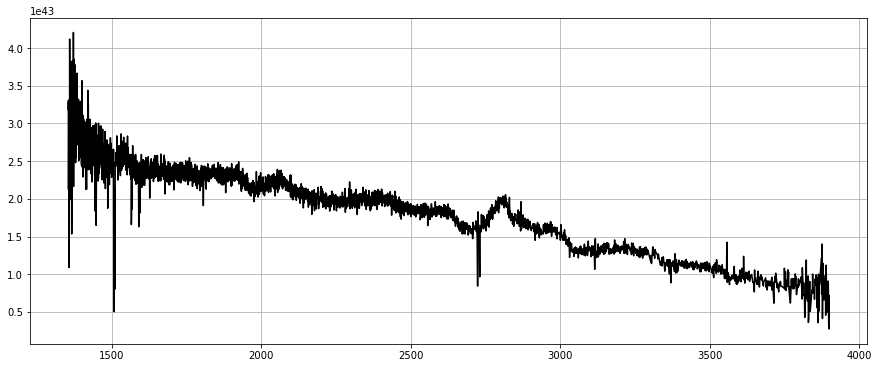

In [23]:
fig, ax    = plt.subplots(1, 1, figsize = (15, 6))

h_flux2     = h_data["flux"][hspec_J0945_1009[number][1].data["and_mask"]==0] * 10**(-17)
h_lambda   = 10**h_data["loglam"][hspec_J0945_1009[number][1].data["and_mask"]==0]

luminosity = h_flux2 * (4 * 3.14 * 1.32 * 10**28 * 1.66)**2  

plt.plot(h_lambda/(1.66 + 1), luminosity, "k-")

plt.grid()

### De-reddening

Note that [K. Hryniewicz et al. 2010](https://academic.oup.com/mnras/article/404/4/2028/1087097) use E(B-V) = 0.06 while [Marcin Marculewicz and Marek Nikolajuk 2020](https://iopscience.iop.org/article/10.3847/1538-4357/ab9597) use A_v = 0.06 and R_v = 3.1 which results in E(B-V) = A_V/R_V = 0.02. I go with E(B-V) = 0.19 $\sim$ 0.02. I use A_V = 0.060 because it is given in NED data base (for this quasar) and I found a value of A_V = 0.019 using the method above (according to [Chen Hu et al. 2008](https://iopscience.iop.org/article/10.1086/591838)).

In [24]:
def extinction_coefficient(x, F_obs, E_b_v, R_v):
    """This function follows the equations 41 and 4b of Jason A. Cardelli et al. 1989.
    Also, note that we use the inverse of the micrometer as input. Note that a and b 
    coefficients are arrays as they are wavelength dependent.
    """
    a = 1.752 - 0.316 * x - 0.104/((x - 4.67)**2 + 0.341)
    
    b = - 3.090 + 1.825 * x + 1.206/((x - 4.62)**2 + 0.263)
    
    A_lambda = E_b_v * (a * R_v + b)
    
    F_int    = F_obs * 10 ** (A_lambda/2.5)
    
    return F_int

In [25]:
input_x         = 1/(h_lambda * 10 **(-4))
dereddened_flux = extinction_coefficient(input_x, h_flux, 0.019, 3.1)


### Flux plot

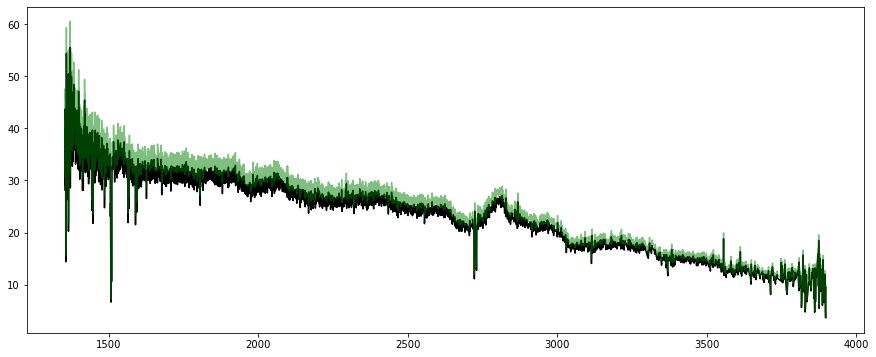

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (15, 6))

plt.plot(h_lambda/(1.66 + 1), h_flux, "k-")
plt.plot(h_lambda/(1.66 + 1), dereddened_flux, "g-", alpha = 0.5)


### Luminosity plot

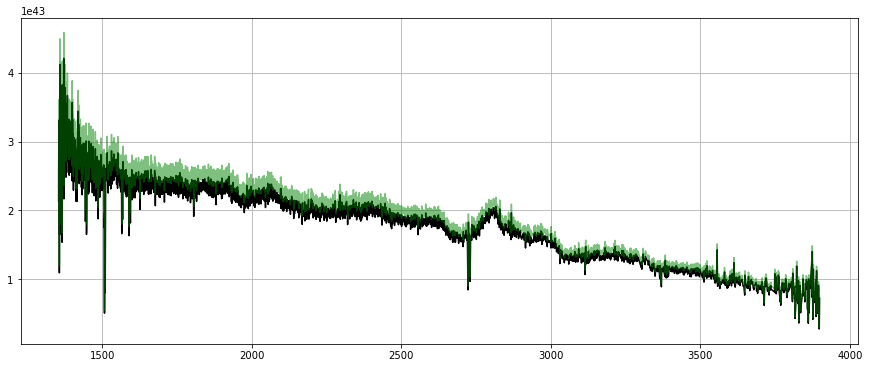

In [27]:
fig, ax    = plt.subplots(1, 1, figsize = (15, 6))

h_flux2    = h_data["flux"][hspec_J0945_1009[number][1].data["and_mask"]==0] * 10**(-17)
h_lambda   = 10**h_data["loglam"][hspec_J0945_1009[number][1].data["and_mask"]==0]
h_flux_de  = dereddened_flux  * 10**(-17) 


luminosity     = h_flux2    * (4 * numpy.pi * 1.32 * 10**28 * 1.66)**2  
luminosity_de  = h_flux_de  * (4 * numpy.pi * 1.32 * 10**28 * 1.66)**2  

plt.plot(h_lambda/(1.66 + 1), luminosity, "k-")
plt.plot(h_lambda/(1.66 + 1), luminosity_de, "g-", alpha = 0.5)

# ax.set_xlim(1400)
plt.grid()

## Binning the spectrum using astropy library

In [28]:
def binner(lambda_wave, flux, lambda_range, bin_size = 1):
    
    """Note that lambda needs to be shifted to its rest frame. This is NOT done here!"""
    
    from specutils import Spectrum1D
    from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler, SplineInterpolatedResampler

    lambda_start      = lambda_range[0]
    lambda_end        = lambda_range[1] + 1
    
    binned_lamb       = lambda_wave.astype("float32") * u.AA
    binned_flux       = flux.astype("float32")        * u.Unit('erg cm-2 s-1 AA-1')
    input_spec_binned = Spectrum1D(spectral_axis = binned_lamb, flux = binned_flux)
    
    new_disp_grid     = numpy.arange(lambda_start, lambda_end, bin_size) * u.AA

    fluxcon           = FluxConservingResampler()
    new_spec_fluxcon  = fluxcon(input_spec_binned, new_disp_grid)

    return new_spec_fluxcon.spectral_axis.to_value().astype("float32"), new_spec_fluxcon.flux.to_value().astype("float32")

In [29]:
spec_lambda   = h_lambda/(1 + 1.66)
spec_flux     = h_flux
fe_lambda     = fe_uv["wave_length"].to_numpy()
fe_flux       = fe_uv["flux_density"].to_numpy()
fe_lambda_ves = fe2_3_ves["lambda_wave"].to_numpy()
fe_flux_ves   = fe2_3_ves["flux"].to_numpy()

lmabda_range = [int(spec_lambda.min()), int(spec_lambda.max())]
# lmabda_range = [2200, 3501] # Iron limit

binned_spec_lambda, binned_spec_flux    = binner(spec_lambda, spec_flux, lmabda_range)
# binned_iron_lambda, binned_iron_flux    = binner(fe_lambda, fe_flux, lmabda_range)
binned_error_lambda, binned_error_flux  = binner(spec_lambda, flux_error, lmabda_range)
binned_spec_lambda, binned_spec_flux_de = binner(spec_lambda, dereddened_flux, lmabda_range)
binned_iron_lambda, binned_iron_flux    = binner(fe_lambda_ves, fe_flux_ves, lmabda_range)


/home/nbal@storm.internal/miniconda3/envs/nozhan_test_env_2/lib/python3.10/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Removing the nan values and normalizing the rebinned iron template

In [30]:
nan_mask = numpy.argwhere(numpy.isnan(binned_iron_flux))

In [31]:
numpy.argwhere(numpy.isnan(binned_iron_flux))

array([[1736],
       [1737],
       [1738],
       [1739],
       [1740],
       [1741],
       [1742],
       [1743],
       [1744],
       [1745],
       [1746],
       [1747],
       [1748],
       [1749],
       [1750],
       [1751],
       [1752],
       [1753],
       [1754],
       [1755],
       [1756],
       [1757],
       [1758],
       [1759],
       [1760],
       [1761],
       [1762],
       [1763],
       [1764],
       [1765],
       [1766],
       [1767],
       [1768],
       [1769],
       [1770],
       [1771],
       [1772],
       [1773],
       [1774],
       [1775],
       [1776],
       [1777],
       [1778],
       [1779],
       [1780],
       [1781],
       [1782],
       [1783],
       [1784],
       [1785],
       [1786],
       [1787],
       [1788],
       [1789],
       [1790],
       [1791],
       [1792],
       [1793],
       [1794],
       [1795],
       [1796],
       [1797],
       [1798],
       [1799],
       [1800],
       [1801],
       [18

In [32]:
iron_nan_removed = numpy.delete(binned_iron_flux, nan_mask)

In [33]:
binned_iron_flux[nan_mask] = 0.0#iron_nan_removed.mean()

In [34]:
binned_iron_flux = binned_iron_flux/binned_iron_flux.max()

In [35]:
binned_iron_flux.shape

(2545,)

### Plotting the binned data

(2200.0, 3501.0)

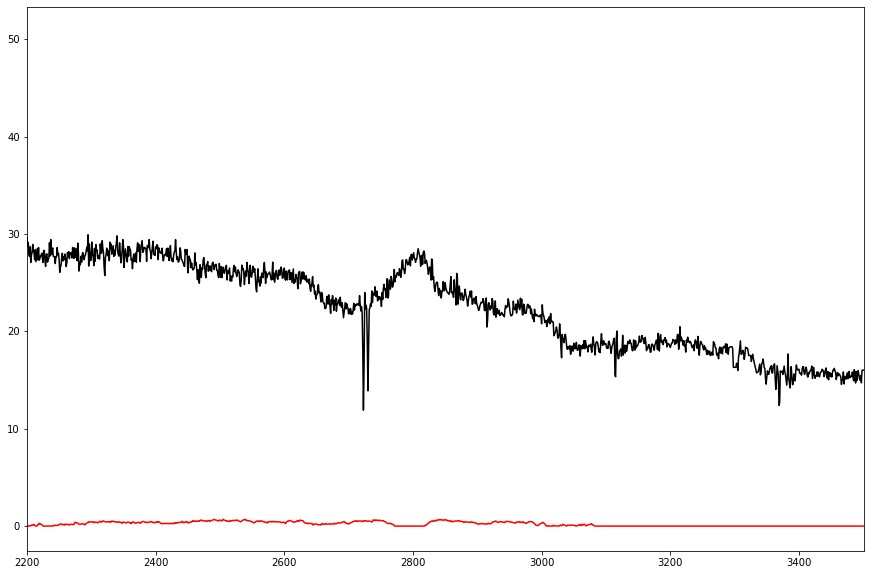

In [36]:
f, ax = plt.subplots(figsize = (15, 10))

ax.plot(binned_spec_lambda, binned_spec_flux_de, "-k")
ax.plot(binned_iron_lambda, binned_iron_flux, "-r")

ax.set_xlim(2200, 3501)#(2200, 3501) (2715, 2850)

### Window extraction

See table 1 of K. Hryniewicz et al. 2010.

In [37]:
def spec_spliter(lambda_array, flux_array, error_array, iron_array, input_window):
    lambda_list = []
    flux_list   = []
    error_list  = []
    iron_list   = []
    for window in input_window:
        start = window[0]
        end   = window[1]
        start_index = numpy.where(lambda_array == start)[0][0]
        end_index   = numpy.where(lambda_array == end)[0][0]
        lambda_list = lambda_list  + lambda_array[start_index:end_index + 1].tolist()
        flux_list   = flux_list    + flux_array[start_index:end_index   + 1].tolist()
        error_list  = error_list   + error_array[start_index:end_index  + 1].tolist()
        iron_list   = iron_list    + iron_array[start_index:end_index   + 1].tolist()

    return numpy.array(lambda_list), numpy.array(flux_list), numpy.array(error_list), numpy.array(iron_list)

In [38]:
# lambda_array, flux_array, flux_error, iron_array = spec_spliter(binned_spec_lambda, binned_spec_flux_de, binned_error_flux, binned_iron_flux, [(2250,2300), (2450,2650), (2850,3070)])

lambda_array2, flux_array2, flux_error2, iron_array2 = spec_spliter(binned_spec_lambda, binned_spec_flux_de, \
                                                                    binned_error_flux, binned_iron_flux, \
                                                                    [(1455, 1470), (1685, 1700), (2020, 2120), \
                                                                     (2190, 2210), (2250, 2300), (2450, 2650),
                                                                    (2850, 3070)])

## Parameter estimation using EMCEE library (it failed)

I need to check this to see what the problem is!

In [83]:
def model(parameter_array, wavelength, y_obs, y_err, iron_value, lambda_null = 2599):
    
    a_c   = parameter_array[0]
    alpha = parameter_array[1]
    a_t   = parameter_array[2]
    sigma = parameter_array[3]
    
    
    # ln_prior evaluation
    if 20.0 < a_c < 60.0 and -2.0 < alpha < 2.0 and -5.0 < a_t < 5.0 and 1000. < sigma < 4000.0:
    
        ln_prior = 0.0
        
    else:
        
        ln_prior = -numpy.inf
    
    kernel     = gaussian_filter(iron_value, sigma = sigma, mode = "nearest")#Gaussian1DKernel(stddev = 40)

    continuum  = a_c * (wavelength/lambda_null) ** alpha
    
    iron       = a_t * kernel#convolve(iron_value, kernel, normalize_kernel=True, boundary='extend')
#     print("---> ", continuum.shape, iron.shape)
    y_model    = continuum + iron
    
    ln_likeli  = -0.5 * (((y_obs - y_model)/y_err)**2).sum()
    
    return ln_prior + ln_likeli

In [93]:
data     = (lambda_array, flux_array, flux_error, iron_array)
nwalkers = 128
niter    = 5000
initial  = numpy.array([1.0, 1.0, 0.3, 40.])
ndim     = len(initial)
p0       = [numpy.array(initial) + 1e-2 * numpy.random.randn(ndim) for i in range(nwalkers)]

In [94]:
def main(p0, nwalkers, niter, ndim, lnprob, data):
    sampler  = emcee.EnsembleSampler(nwalkers, ndim, model, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [95]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,model,data)


Running burn-in...
Running production...


In [96]:
def mg_model(wavelength, iron_value, parameter_array):
    a_c   = parameter_array[0]
    alpha = parameter_array[1]
    a_t   = parameter_array[2]
    sigma = parameter_array[3]
    
    kernel     = Gaussian1DKernel(stddev = sigma)

    continuum  = a_c * (wavelength/2599.) ** -alpha
    
    iron       = a_t * convolve(iron_value, kernel, normalize_kernel=True, boundary='extend')

    y_model    = continuum + iron
    
    return y_model

In [97]:
plt.rcParams['figure.figsize'] = (20,10)

def plotter(sampler, lambda_wave=lambda_array, flux=flux_array):
    plt.ion()
#     plt.plot(lambda_wave,flux,label='spectrum fit')
    samples = sampler.flatchain
    for param in samples[numpy.random.randint(len(samples), size=100)]:
        plt.plot(lambda_wave, mg_model(lambda_array, iron_array, param), color="r", alpha=0.1) # color="C1"
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('Wave length')
    plt.ylabel(r'$Flux$')
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


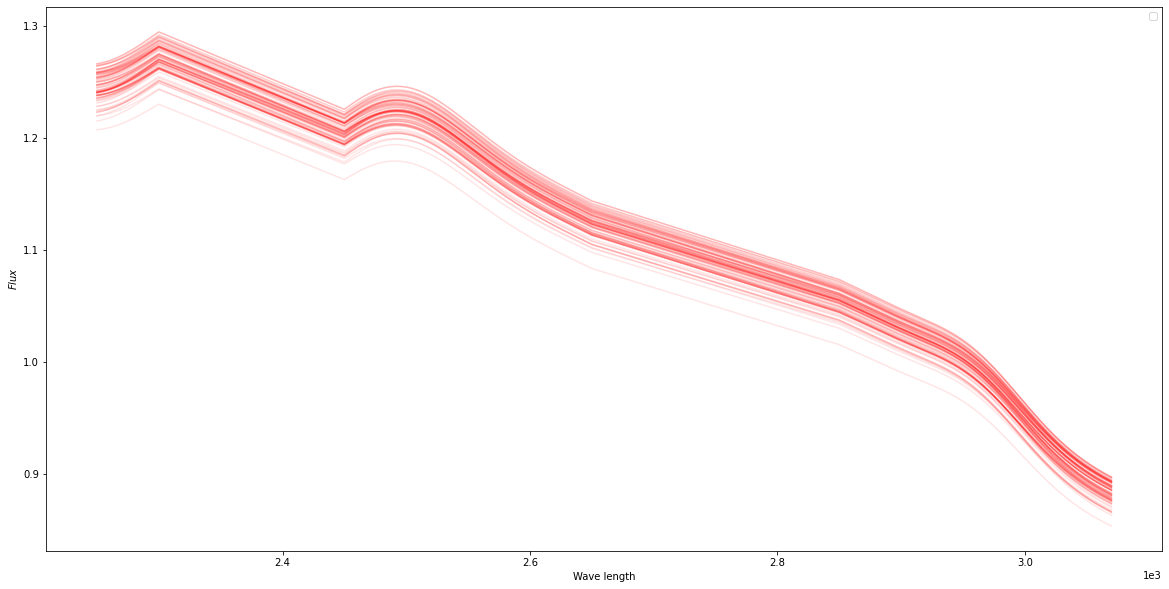

In [98]:
plotter(sampler)


In [50]:
samples = sampler.flatchain
samples[numpy.argmax(sampler.flatlnprobability)]

array([1.00480860e+00, 9.93472157e-01, 2.88532167e-01, 2.49997773e+03])

## Parameter estimation using Hamiltonian Monte Carlo, HMC, method (using Pyro)

In [39]:
import pyro
import scipy
import torch
from pyro.infer import MCMC, HMC, NUTS
import pyro.distributions as dist

import torch.nn.functional as F


/home/nbal@storm.internal/miniconda3/envs/nozhan_test_env_2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Note
I use eq. 2a, 2b, and 2c of [Zhefu Yu et al. 2021](https://academic.oup.com/mnras/article/507/3/3771/6342128) to construct the flux model of the quasar. Note that in their model they consider the broadening parameter, $\sigma$, a free parameter to be estimated, however, they mention that they set a very small range for this parameter. On the other hand, in section 2.1, [K. Hryniewicz et al. 2010](https://academic.oup.com/mnras/article/404/4/2028/1087097) state that they broaden the Fe II template using fixed $\sigma$ of increments of 250 km/s from 900 to 9000 km/s and they use these fixed values to find which one works the best fit. In my experience, fixing $\sigma$ works best makes the NUTS method to converge while leaving it as a free parameter breaks the model!

In [40]:
def con_iron_dist(wavelength, y_obs, iron_value):
    
    # I define uniform distributions for all parameters
    a_c         = pyro.sample("a_c", dist.Normal(0.0, 50.0))
    alpha       = pyro.sample("alpha", dist.Normal(0.0, 5.0))
    a_t         = pyro.sample("a_t", dist.Normal(0.0, 30.0))
#     sigma_ker   = pyro.sample("sigma_ker", dist.Uniform(40.0, 45.0))
    sigma_norm  = pyro.sample("sigma_norm", dist.HalfNormal(20.))

#     kernel      = torch.from_numpy(gaussian_filter(iron_value, sigma = sigma_ker.detach().numpy().item(), mode = "nearest"))
    kernel      = torch.from_numpy(gaussian_filter(iron_value, sigma = 25, mode = "nearest")) #33.76

    mu          = pyro.deterministic("mu", a_c * (wavelength/2599.) ** (alpha) + a_t * kernel)
#     mu          = pyro.deterministic("mu", a_t * kernel)
    
    flux        = pyro.sample("flux", dist.Normal(mu, sigma_norm), obs = y_obs)
        
    return flux


In [41]:
start = time.time()

# hmc_kernel_linear     = HMC(con_iron_dist, step_size= 1.87e-05, num_steps= 10, adapt_step_size = True, \
#                            target_accept_prob = 0.80)

# mcmc_linear           = MCMC(hmc_kernel_linear, num_samples=10000, warmup_steps=2000, num_chains = 4)


nuts_kernel_linear    = NUTS(con_iron_dist, step_size= 1.87e-05, adapt_step_size = True)

nuts_linear           = MCMC(nuts_kernel_linear, num_samples=10000, warmup_steps=2000, num_chains = 4)


# mcmc_linear.run(mass_Adelie, flipper_length_Adelie)

# nuts_linear.run(torch.from_numpy(lambda_array), torch.from_numpy(flux_array), torch.from_numpy(iron_array))
nuts_linear.run(torch.from_numpy(lambda_array2), torch.from_numpy(flux_array2), torch.from_numpy(iron_array2))


print(time.time() - start)

Warmup [2]:   0%|          | 0/12000 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/12000 [00:00, ?it/s]


Warmup [2]:   0%|          | 1/12000 [00:00,  2.92it/s, step size=5.59e-03, acc. prob=0.000]

Warmup [3]:   0%|          | 1/12000 [00:00,  2.83it/s, step size=2.24e-02, acc. prob=0.000]


Warmup [1]:   0%|          | 8/12000 [00:00, 20.23it/s, step size=2.72e-02, acc. prob=0.750]


Warmup [4]:   0%|          | 8/12000 [00:00, 20.36it/s, step size=5.45e-02, acc. prob=0.750]

Warmup [2]:   0%|          | 15/12000 [00:00, 35.28it/s, step size=2.49e-02, acc. prob=0.801]

Warmup [3]:   0%|          | 12/12000 [00:00, 26.25it/s, step size=5.92e-02, acc. prob=0.787]


Warmup [4]:   0%|          | 12/12000 [00:00, 16.50it/s, step size=5.88e-02, acc. prob=0.769]


Warmup [4]:   0%|          | 15/12000 [00:01, 13.29it/s, step size=1.82e-02, acc. prob=0.749]

Warmup [1]:   0%|          | 12/12000 [00:01,  8.92it/s, step size=1.84e-02, acc. prob=0.756]


Warmup [4]:   0%|          | 17/12000

Warmup [1]:   1%|          | 133/12000 [00:11, 26.06it/s, step size=2.26e-01, acc. prob=0.781]


Warmup [1]:   1%|          | 137/12000 [00:11, 28.08it/s, step size=5.63e-01, acc. prob=0.784]

Warmup [3]:   2%|▏         | 235/12000 [00:11, 17.83it/s, step size=1.58e-01, acc. prob=0.783]


Warmup [2]:   1%|▏         | 178/12000 [00:11, 16.06it/s, step size=2.06e-01, acc. prob=0.785]

Warmup [1]:   1%|          | 145/12000 [00:11, 28.15it/s, step size=1.66e-01, acc. prob=0.781]

Warmup [2]:   2%|▏         | 186/12000 [00:11, 22.69it/s, step size=3.88e-01, acc. prob=0.787]


Warmup [1]:   1%|          | 148/12000 [00:11, 27.11it/s, step size=4.08e-01, acc. prob=0.784]

Warmup [1]:   1%|▏         | 152/12000 [00:11, 28.85it/s, step size=4.94e-01, acc. prob=0.783]

Warmup [3]:   2%|▏         | 248/12000 [00:11, 24.72it/s, step size=4.11e-01, acc. prob=0.785]


Warmup [2]:   2%|▏         | 189/12000 [00:11, 17.74it/s, step size=1.41e-01, acc. prob=0.785]


Warmup [4]:   2%|▏         | 204/12

Warmup [4]:   3%|▎         | 374/12000 [00:19, 27.30it/s, step size=3.17e-01, acc. prob=0.784]

Warmup [2]:   3%|▎         | 378/12000 [00:19, 29.02it/s, step size=2.27e-01, acc. prob=0.785]


Warmup [2]:   3%|▎         | 382/12000 [00:19, 27.10it/s, step size=3.72e-01, acc. prob=0.786]

Warmup [3]:   4%|▍         | 469/12000 [00:19, 25.91it/s, step size=4.28e-01, acc. prob=0.785]


Warmup [2]:   3%|▎         | 386/12000 [00:19, 29.82it/s, step size=3.06e-01, acc. prob=0.786]

Warmup [2]:   3%|▎         | 390/12000 [00:19, 31.71it/s, step size=2.33e-01, acc. prob=0.786]


Warmup [1]:   3%|▎         | 354/12000 [00:19, 24.80it/s, step size=3.19e-01, acc. prob=0.789]

Warmup [1]:   3%|▎         | 357/12000 [00:19, 24.68it/s, step size=4.87e-01, acc. prob=0.789]


Warmup [4]:   3%|▎         | 391/12000 [00:19, 31.44it/s, step size=2.50e-01, acc. prob=0.784]

Warmup [1]:   3%|▎         | 360/12000 [00:19, 23.92it/s, step size=3.80e-01, acc. prob=0.789]


Warmup [4]:   3%|▎         | 395/12

Warmup [3]:   6%|▌         | 691/12000 [00:26, 25.52it/s, step size=3.65e-01, acc. prob=0.787]


Warmup [2]:   5%|▍         | 563/12000 [00:27, 25.58it/s, step size=4.62e-01, acc. prob=0.789]

Warmup [3]:   6%|▌         | 694/12000 [00:27, 25.19it/s, step size=2.66e-01, acc. prob=0.787]


Warmup [1]:   5%|▍         | 543/12000 [00:27, 29.95it/s, step size=3.67e-01, acc. prob=0.791]

Warmup [3]:   6%|▌         | 698/12000 [00:27, 25.87it/s, step size=3.33e-01, acc. prob=0.787]


Warmup [1]:   5%|▍         | 548/12000 [00:27, 31.71it/s, step size=3.53e-01, acc. prob=0.791]

Warmup [3]:   6%|▌         | 702/12000 [00:27, 27.87it/s, step size=3.41e-01, acc. prob=0.788]


Warmup [1]:   5%|▍         | 553/12000 [00:27, 35.61it/s, step size=2.98e-01, acc. prob=0.791]

Warmup [2]:   5%|▍         | 574/12000 [00:27, 24.15it/s, step size=3.57e-01, acc. prob=0.788]


Warmup [1]:   5%|▍         | 557/12000 [00:27, 33.85it/s, step size=1.54e-01, acc. prob=0.790]

Warmup [2]:   5%|▍         | 579/12

Warmup [2]:   7%|▋         | 787/12000 [00:34, 34.31it/s, step size=4.18e-01, acc. prob=0.791]

Warmup [3]:   8%|▊         | 908/12000 [00:34, 25.35it/s, step size=1.75e-01, acc. prob=0.788]


Warmup [2]:   7%|▋         | 793/12000 [00:34, 39.22it/s, step size=4.99e-01, acc. prob=0.791]

Warmup [3]:   8%|▊         | 911/12000 [00:34, 23.75it/s, step size=6.10e-01, acc. prob=0.789]


Warmup [1]:   6%|▋         | 763/12000 [00:34, 30.25it/s, step size=2.49e-01, acc. prob=0.792]

Warmup [3]:   8%|▊         | 914/12000 [00:34, 21.50it/s, step size=2.63e-01, acc. prob=0.788]


Warmup [2]:   7%|▋         | 803/12000 [00:34, 31.46it/s, step size=4.58e-01, acc. prob=0.791]

Warmup [3]:   8%|▊         | 917/12000 [00:34, 20.57it/s, step size=6.15e-01, acc. prob=0.789]


Warmup [1]:   6%|▋         | 771/12000 [00:34, 30.06it/s, step size=2.23e-01, acc. prob=0.792]

Warmup [3]:   8%|▊         | 923/12000 [00:34, 27.73it/s, step size=4.48e-01, acc. prob=0.788]


Warmup [4]:   7%|▋         | 805/12

Warmup [2]:   8%|▊         | 974/12000 [00:42, 29.86it/s, step size=3.85e-01, acc. prob=0.790]


Warmup [4]:   8%|▊         | 982/12000 [00:42, 22.22it/s, step size=2.99e-01, acc. prob=0.788]

Warmup [2]:   8%|▊         | 979/12000 [00:42, 32.33it/s, step size=3.57e-01, acc. prob=0.790]


Warmup [4]:   8%|▊         | 986/12000 [00:42, 24.74it/s, step size=4.62e-01, acc. prob=0.788]

Warmup [1]:   8%|▊         | 973/12000 [00:42, 22.68it/s, step size=2.32e-01, acc. prob=0.792]]


Warmup [2]:   8%|▊         | 984/12000 [00:42, 31.29it/s, step size=2.36e-01, acc. prob=0.790]

Warmup [1]:   8%|▊         | 976/12000 [00:42, 21.91it/s, step size=4.28e-01, acc. prob=0.793]]

Warmup [2]:   8%|▊         | 988/12000 [00:42, 30.15it/s, step size=2.42e-01, acc. prob=0.790]


Warmup [1]:   8%|▊         | 981/12000 [00:42, 27.79it/s, step size=4.89e-01, acc. prob=0.793]


Warmup [4]:   8%|▊         | 996/12000 [00:42, 24.74it/s, step size=5.22e-01, acc. prob=0.789]

Warmup [2]:   8%|▊         | 992/

Warmup [2]:  10%|▉         | 1176/12000 [00:49, 33.30it/s, step size=2.11e-01, acc. prob=0.790]

Warmup [3]:  11%|█▏        | 1379/12000 [00:49, 26.97it/s, step size=4.14e-01, acc. prob=0.791]


Warmup [2]:  10%|▉         | 1180/12000 [00:49, 31.35it/s, step size=3.82e-01, acc. prob=0.791]

Warmup [3]:  12%|█▏        | 1383/12000 [00:49, 27.09it/s, step size=3.71e-01, acc. prob=0.791]


Warmup [2]:  10%|▉         | 1184/12000 [00:49, 33.30it/s, step size=2.52e-01, acc. prob=0.791]


Warmup [4]:  10%|▉         | 1199/12000 [00:49, 32.20it/s, step size=3.69e-01, acc. prob=0.789]

Warmup [2]:  10%|▉         | 1188/12000 [00:49, 32.28it/s, step size=4.94e-01, acc. prob=0.791]


Warmup [1]:  10%|▉         | 1186/12000 [00:49, 24.83it/s, step size=3.43e-01, acc. prob=0.793]

Warmup [2]:  10%|▉         | 1192/12000 [00:49, 30.66it/s, step size=3.93e-01, acc. prob=0.791]


Warmup [4]:  10%|█         | 1208/12000 [00:49, 33.06it/s, step size=4.95e-01, acc. prob=0.790]

Warmup [2]:  10%|▉       

Warmup [2]:  12%|█▏        | 1382/12000 [00:56, 29.40it/s, step size=2.97e-01, acc. prob=0.791]

Warmup [1]:  12%|█▏        | 1404/12000 [00:56, 33.88it/s, step size=3.06e-01, acc. prob=0.794]


Warmup [4]:  12%|█▏        | 1404/12000 [00:56, 28.84it/s, step size=3.84e-01, acc. prob=0.790]

Warmup [1]:  12%|█▏        | 1408/12000 [00:56, 33.66it/s, step size=3.06e-01, acc. prob=0.794]


Warmup [4]:  12%|█▏        | 1408/12000 [00:56, 30.89it/s, step size=5.53e-01, acc. prob=0.791]

Warmup [2]:  12%|█▏        | 1390/12000 [00:56, 27.89it/s, step size=4.11e-01, acc. prob=0.792]


Warmup [1]:  12%|█▏        | 1418/12000 [00:56, 37.05it/s, step size=3.77e-01, acc. prob=0.794]

Warmup [2]:  12%|█▏        | 1394/12000 [00:56, 29.36it/s, step size=3.42e-01, acc. prob=0.792]


Warmup [2]:  12%|█▏        | 1397/12000 [00:56, 28.93it/s, step size=3.08e-01, acc. prob=0.791]

Warmup [3]:  14%|█▎        | 1649/12000 [00:56, 35.94it/s, step size=5.07e-01, acc. prob=0.792]


Warmup [1]:  12%|█▏      

Warmup [2]:  13%|█▎        | 1607/12000 [01:03, 33.19it/s, step size=3.63e-01, acc. prob=0.792]

Warmup [1]:  14%|█▎        | 1647/12000 [01:03, 31.68it/s, step size=3.90e-01, acc. prob=0.795]


Warmup [4]:  14%|█▎        | 1627/12000 [01:03, 29.35it/s, step size=3.48e-01, acc. prob=0.791]

Warmup [1]:  14%|█▍        | 1651/12000 [01:03, 32.06it/s, step size=4.35e-01, acc. prob=0.795]


Warmup [4]:  14%|█▎        | 1631/12000 [01:03, 28.66it/s, step size=3.36e-01, acc. prob=0.791]

Warmup [1]:  14%|█▍        | 1655/12000 [01:03, 31.36it/s, step size=3.33e-01, acc. prob=0.795]


Warmup [4]:  14%|█▎        | 1634/12000 [01:03, 28.29it/s, step size=3.10e-01, acc. prob=0.791]

Warmup [2]:  14%|█▎        | 1620/12000 [01:03, 29.86it/s, step size=3.41e-01, acc. prob=0.792]


Warmup [4]:  14%|█▎        | 1637/12000 [01:03, 28.00it/s, step size=3.73e-01, acc. prob=0.791]

Warmup [3]:  16%|█▌        | 1881/12000 [01:03, 42.28it/s, step size=4.41e-01, acc. prob=0.793]

Warmup [1]:  14%|█▍       

Warmup [4]:  15%|█▌        | 1854/12000 [01:10, 26.48it/s, step size=3.34e-01, acc. prob=0.792]

Warmup [2]:  15%|█▌        | 1852/12000 [01:10, 37.81it/s, step size=3.89e-01, acc. prob=0.793]


Warmup [4]:  15%|█▌        | 1858/12000 [01:10, 26.68it/s, step size=4.82e-01, acc. prob=0.792]

Warmup [1]:  16%|█▌        | 1896/12000 [01:10, 33.94it/s, step size=3.78e-01, acc. prob=0.795]


Warmup [2]:  15%|█▌        | 1858/12000 [01:10, 38.66it/s, step size=3.24e-01, acc. prob=0.793]

Warmup [1]:  16%|█▌        | 1901/12000 [01:10, 36.27it/s, step size=3.88e-01, acc. prob=0.795]


Warmup [1]:  16%|█▌        | 1906/12000 [01:10, 38.34it/s, step size=3.95e-01, acc. prob=0.795]

Sample [3]:  17%|█▋        | 2061/12000 [01:10, 20.99it/s, step size=2.34e-01, acc. prob=0.957]


Warmup [1]:  16%|█▌        | 1910/12000 [01:10, 36.72it/s, step size=4.35e-01, acc. prob=0.796]

Sample [3]:  17%|█▋        | 2064/12000 [01:10, 21.67it/s, step size=2.34e-01, acc. prob=0.957]


Warmup [2]:  16%|█▌      

Sample [1]:  17%|█▋        | 2084/12000 [01:17, 26.89it/s, step size=3.02e-01, acc. prob=0.923]

Sample [3]:  18%|█▊        | 2212/12000 [01:17, 19.54it/s, step size=2.34e-01, acc. prob=0.956]


Sample [4]:  17%|█▋        | 2056/12000 [01:17, 23.83it/s, step size=2.93e-01, acc. prob=0.911]

Sample [1]:  17%|█▋        | 2088/12000 [01:17, 27.46it/s, step size=3.02e-01, acc. prob=0.925]


Sample [2]:  17%|█▋        | 2058/12000 [01:17, 26.77it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  17%|█▋        | 2092/12000 [01:17, 29.69it/s, step size=3.02e-01, acc. prob=0.926]


Sample [1]:  17%|█▋        | 2096/12000 [01:17, 29.34it/s, step size=3.02e-01, acc. prob=0.927]

Sample [3]:  18%|█▊        | 2220/12000 [01:18, 18.32it/s, step size=2.34e-01, acc. prob=0.957]


Sample [1]:  18%|█▊        | 2101/12000 [01:18, 33.58it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  17%|█▋        | 2069/12000 [01:18, 25.29it/s, step size=2.93e-01, acc. prob=0.920]

Sample [1]:  18%|█▊      

Sample [1]:  19%|█▉        | 2268/12000 [01:24, 24.83it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  20%|█▉        | 2362/12000 [01:24, 21.31it/s, step size=2.34e-01, acc. prob=0.956]


Sample [1]:  19%|█▉        | 2271/12000 [01:24, 23.67it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  19%|█▊        | 2238/12000 [01:24, 25.64it/s, step size=3.16e-01, acc. prob=0.915]

Sample [3]:  20%|█▉        | 2365/12000 [01:24, 20.79it/s, step size=2.34e-01, acc. prob=0.957]


Sample [1]:  19%|█▉        | 2274/12000 [01:24, 22.27it/s, step size=3.02e-01, acc. prob=0.924]

Sample [2]:  19%|█▊        | 2244/12000 [01:25, 24.46it/s, step size=3.16e-01, acc. prob=0.913]


Sample [4]:  19%|█▊        | 2246/12000 [01:25, 28.80it/s, step size=2.93e-01, acc. prob=0.923]

Sample [2]:  19%|█▊        | 2248/12000 [01:25, 27.15it/s, step size=3.16e-01, acc. prob=0.914]


Sample [4]:  19%|█▉        | 2250/12000 [01:25, 27.99it/s, step size=2.93e-01, acc. prob=0.923]

Sample [2]:  19%|█▉      

Sample [2]:  20%|██        | 2422/12000 [01:31, 29.04it/s, step size=3.16e-01, acc. prob=0.908]


Sample [4]:  20%|██        | 2403/12000 [01:31, 20.82it/s, step size=2.93e-01, acc. prob=0.927]

Sample [2]:  20%|██        | 2426/12000 [01:32, 29.70it/s, step size=3.16e-01, acc. prob=0.907]

Sample [3]:  21%|██        | 2507/12000 [01:32, 19.32it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  20%|██        | 2431/12000 [01:32, 33.39it/s, step size=3.16e-01, acc. prob=0.907]

Sample [1]:  20%|██        | 2453/12000 [01:32, 23.78it/s, step size=3.02e-01, acc. prob=0.926]


Sample [1]:  20%|██        | 2456/12000 [01:32, 22.35it/s, step size=3.02e-01, acc. prob=0.926]

Sample [2]:  20%|██        | 2438/12000 [01:32, 28.30it/s, step size=3.16e-01, acc. prob=0.907]


Sample [2]:  20%|██        | 2442/12000 [01:32, 30.04it/s, step size=3.16e-01, acc. prob=0.907]

Sample [3]:  21%|██        | 2514/12000 [01:32, 14.43it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  21%|██      

Sample [3]:  22%|██▏       | 2646/12000 [01:39, 23.85it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  22%|██▏       | 2610/12000 [01:39, 24.08it/s, step size=3.16e-01, acc. prob=0.908]

Sample [3]:  22%|██▏       | 2649/12000 [01:39, 23.13it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  22%|██▏       | 2630/12000 [01:39, 28.90it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  22%|██▏       | 2652/12000 [01:39, 22.01it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  22%|██▏       | 2633/12000 [01:39, 25.60it/s, step size=3.02e-01, acc. prob=0.925]

Sample [3]:  22%|██▏       | 2655/12000 [01:39, 21.25it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  22%|██▏       | 2636/12000 [01:39, 25.75it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  22%|██▏       | 2628/12000 [01:39, 34.57it/s, step size=3.16e-01, acc. prob=0.908]

Sample [1]:  22%|██▏       | 2639/12000 [01:39, 25.03it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  22%|██▏    

Sample [4]:  23%|██▎       | 2751/12000 [01:46, 31.54it/s, step size=2.93e-01, acc. prob=0.925]

Sample [2]:  23%|██▎       | 2806/12000 [01:46, 31.97it/s, step size=3.16e-01, acc. prob=0.907]


Sample [4]:  23%|██▎       | 2755/12000 [01:46, 24.56it/s, step size=2.93e-01, acc. prob=0.925]

Sample [2]:  23%|██▎       | 2810/12000 [01:46, 33.81it/s, step size=3.16e-01, acc. prob=0.907]

Sample [3]:  23%|██▎       | 2803/12000 [01:46, 20.40it/s, step size=2.34e-01, acc. prob=0.957]


Sample [2]:  23%|██▎       | 2814/12000 [01:46, 32.74it/s, step size=3.16e-01, acc. prob=0.907]


Sample [1]:  23%|██▎       | 2816/12000 [01:46, 25.79it/s, step size=3.02e-01, acc. prob=0.927]

Sample [2]:  23%|██▎       | 2818/12000 [01:46, 30.28it/s, step size=3.16e-01, acc. prob=0.908]


Sample [1]:  23%|██▎       | 2819/12000 [01:46, 26.71it/s, step size=3.02e-01, acc. prob=0.927]

Sample [3]:  23%|██▎       | 2809/12000 [01:46, 20.25it/s, step size=2.34e-01, acc. prob=0.958]


Sample [1]:  24%|██▎     

Sample [1]:  25%|██▍       | 2993/12000 [01:53, 26.87it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  24%|██▍       | 2925/12000 [01:53, 20.40it/s, step size=2.93e-01, acc. prob=0.924]

Sample [1]:  25%|██▍       | 2996/12000 [01:53, 26.60it/s, step size=3.02e-01, acc. prob=0.925]


Sample [4]:  24%|██▍       | 2928/12000 [01:53, 20.90it/s, step size=2.93e-01, acc. prob=0.924]

Sample [2]:  25%|██▍       | 2993/12000 [01:53, 26.80it/s, step size=3.16e-01, acc. prob=0.908]


Sample [2]:  25%|██▍       | 2996/12000 [01:53, 27.08it/s, step size=3.16e-01, acc. prob=0.908]

Sample [1]:  25%|██▌       | 3002/12000 [01:53, 23.94it/s, step size=3.02e-01, acc. prob=0.925]


Sample [2]:  25%|██▌       | 3000/12000 [01:54, 27.09it/s, step size=3.16e-01, acc. prob=0.908]

Sample [3]:  25%|██▍       | 2951/12000 [01:54, 17.70it/s, step size=2.34e-01, acc. prob=0.957]


Sample [1]:  25%|██▌       | 3005/12000 [01:54, 22.45it/s, step size=3.02e-01, acc. prob=0.925]

Sample [2]:  25%|██▌     

Sample [1]:  26%|██▋       | 3176/12000 [02:00, 29.08it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  26%|██▌       | 3097/12000 [02:00, 23.18it/s, step size=2.93e-01, acc. prob=0.925]

Sample [1]:  26%|██▋       | 3179/12000 [02:00, 27.33it/s, step size=3.02e-01, acc. prob=0.923]

Sample [3]:  26%|██▌       | 3094/12000 [02:00, 21.28it/s, step size=2.34e-01, acc. prob=0.957]


Sample [1]:  27%|██▋       | 3182/12000 [02:00, 27.03it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  26%|██▌       | 3103/12000 [02:01, 23.06it/s, step size=2.93e-01, acc. prob=0.925]

Sample [2]:  27%|██▋       | 3183/12000 [02:01, 27.42it/s, step size=3.16e-01, acc. prob=0.908]


Sample [4]:  26%|██▌       | 3106/12000 [02:01, 23.19it/s, step size=2.93e-01, acc. prob=0.925]

Sample [2]:  27%|██▋       | 3186/12000 [02:01, 27.69it/s, step size=3.16e-01, acc. prob=0.908]


Sample [4]:  26%|██▌       | 3109/12000 [02:01, 23.27it/s, step size=2.93e-01, acc. prob=0.925]

Sample [2]:  27%|██▋     

Sample [1]:  28%|██▊       | 3356/12000 [02:07, 28.27it/s, step size=3.02e-01, acc. prob=0.925]


Sample [2]:  28%|██▊       | 3362/12000 [02:07, 26.85it/s, step size=3.16e-01, acc. prob=0.909]

Sample [1]:  28%|██▊       | 3359/12000 [02:07, 26.79it/s, step size=3.02e-01, acc. prob=0.925]


Sample [2]:  28%|██▊       | 3365/12000 [02:07, 25.68it/s, step size=3.16e-01, acc. prob=0.909]

Sample [1]:  28%|██▊       | 3362/12000 [02:08, 26.60it/s, step size=3.02e-01, acc. prob=0.925]

Sample [1]:  28%|██▊       | 3365/12000 [02:08, 26.45it/s, step size=3.02e-01, acc. prob=0.925]


Sample [2]:  28%|██▊       | 3372/12000 [02:08, 27.15it/s, step size=3.16e-01, acc. prob=0.909]

Sample [1]:  28%|██▊       | 3368/12000 [02:08, 25.52it/s, step size=3.02e-01, acc. prob=0.925]


Sample [1]:  28%|██▊       | 3371/12000 [02:08, 24.87it/s, step size=3.02e-01, acc. prob=0.925]


Sample [4]:  27%|██▋       | 3293/12000 [02:08, 21.79it/s, step size=2.93e-01, acc. prob=0.924]

Sample [2]:  28%|██▊     

Sample [3]:  28%|██▊       | 3362/12000 [02:14, 18.24it/s, step size=2.34e-01, acc. prob=0.958]


Sample [1]:  29%|██▉       | 3538/12000 [02:14, 23.34it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  28%|██▊       | 3364/12000 [02:14, 17.94it/s, step size=2.34e-01, acc. prob=0.958]


Sample [1]:  30%|██▉       | 3541/12000 [02:15, 24.74it/s, step size=3.02e-01, acc. prob=0.924]

Sample [2]:  30%|██▉       | 3556/12000 [02:15, 27.23it/s, step size=3.16e-01, acc. prob=0.910]


Sample [2]:  30%|██▉       | 3561/12000 [02:15, 31.15it/s, step size=3.16e-01, acc. prob=0.910]

Sample [1]:  30%|██▉       | 3548/12000 [02:15, 27.36it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  30%|██▉       | 3565/12000 [02:15, 33.36it/s, step size=3.16e-01, acc. prob=0.909]


Sample [4]:  29%|██▉       | 3460/12000 [02:15, 22.92it/s, step size=2.93e-01, acc. prob=0.923]

Sample [1]:  30%|██▉       | 3551/12000 [02:15, 25.30it/s, step size=3.02e-01, acc. prob=0.924]


Sample [1]:  30%|██▉    

Sample [3]:  29%|██▉       | 3497/12000 [02:21, 16.69it/s, step size=2.34e-01, acc. prob=0.957]


Sample [2]:  31%|███       | 3736/12000 [02:21, 32.19it/s, step size=3.16e-01, acc. prob=0.909]

Sample [3]:  29%|██▉       | 3500/12000 [02:21, 19.01it/s, step size=2.34e-01, acc. prob=0.957]


Sample [1]:  31%|███       | 3715/12000 [02:21, 20.60it/s, step size=3.02e-01, acc. prob=0.924]

Sample [1]:  31%|███       | 3718/12000 [02:22, 21.30it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  29%|██▉       | 3508/12000 [02:22, 26.04it/s, step size=2.34e-01, acc. prob=0.957]


Sample [2]:  31%|███       | 3743/12000 [02:22, 26.64it/s, step size=3.16e-01, acc. prob=0.909]


Sample [4]:  30%|███       | 3627/12000 [02:22, 21.09it/s, step size=2.93e-01, acc. prob=0.923]

Sample [1]:  31%|███       | 3725/12000 [02:22, 23.32it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  29%|██▉       | 3514/12000 [02:22, 23.59it/s, step size=2.34e-01, acc. prob=0.957]


Sample [1]:  31%|███     

Sample [1]:  32%|███▏      | 3899/12000 [02:29, 21.42it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  30%|███       | 3645/12000 [02:29, 22.18it/s, step size=2.34e-01, acc. prob=0.958]


Sample [1]:  33%|███▎      | 3902/12000 [02:29, 22.58it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  30%|███       | 3648/12000 [02:29, 20.49it/s, step size=2.34e-01, acc. prob=0.958]


Sample [1]:  33%|███▎      | 3905/12000 [02:29, 24.23it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  32%|███▏      | 3809/12000 [02:29, 25.89it/s, step size=2.93e-01, acc. prob=0.924]

Sample [2]:  33%|███▎      | 3936/12000 [02:29, 22.51it/s, step size=3.16e-01, acc. prob=0.909]


Sample [2]:  33%|███▎      | 3939/12000 [02:29, 23.13it/s, step size=3.16e-01, acc. prob=0.909]

Sample [3]:  30%|███       | 3654/12000 [02:29, 17.33it/s, step size=2.34e-01, acc. prob=0.958]


Sample [2]:  33%|███▎      | 3942/12000 [02:29, 23.56it/s, step size=3.16e-01, acc. prob=0.909]

Sample [1]:  33%|███▎    

Sample [1]:  34%|███▍      | 4078/12000 [02:36, 28.86it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  34%|███▍      | 4103/12000 [02:36, 24.67it/s, step size=3.16e-01, acc. prob=0.910]

Sample [2]:  34%|███▍      | 4106/12000 [02:36, 24.89it/s, step size=3.16e-01, acc. prob=0.910]


Sample [4]:  33%|███▎      | 3964/12000 [02:36, 21.01it/s, step size=2.93e-01, acc. prob=0.924]

Sample [3]:  32%|███▏      | 3799/12000 [02:36, 19.49it/s, step size=2.34e-01, acc. prob=0.958]


Sample [1]:  34%|███▍      | 4087/12000 [02:36, 24.71it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  32%|███▏      | 3802/12000 [02:36, 19.45it/s, step size=2.34e-01, acc. prob=0.958]


Sample [2]:  34%|███▍      | 4112/12000 [02:36, 24.82it/s, step size=3.16e-01, acc. prob=0.910]

Sample [1]:  34%|███▍      | 4093/12000 [02:36, 26.86it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  34%|███▍      | 4115/12000 [02:36, 25.13it/s, step size=3.16e-01, acc. prob=0.910]

Sample [1]:  34%|███▍    

Sample [1]:  35%|███▌      | 4254/12000 [02:43, 23.33it/s, step size=3.02e-01, acc. prob=0.925]

Sample [2]:  36%|███▌      | 4289/12000 [02:43, 31.61it/s, step size=3.16e-01, acc. prob=0.910]


Sample [2]:  36%|███▌      | 4293/12000 [02:43, 31.53it/s, step size=3.16e-01, acc. prob=0.910]

Sample [3]:  33%|███▎      | 3947/12000 [02:43, 21.95it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  36%|███▌      | 4297/12000 [02:43, 29.59it/s, step size=3.16e-01, acc. prob=0.910]

Sample [3]:  33%|███▎      | 3950/12000 [02:43, 22.28it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  36%|███▌      | 4264/12000 [02:43, 24.61it/s, step size=3.02e-01, acc. prob=0.925]

Sample [1]:  36%|███▌      | 4267/12000 [02:43, 25.44it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  35%|███▍      | 4141/12000 [02:43, 22.70it/s, step size=2.93e-01, acc. prob=0.924]

Sample [1]:  36%|███▌      | 4270/12000 [02:43, 25.67it/s, step size=3.02e-01, acc. prob=0.925]


Sample [2]:  36%|███▌    

Sample [2]:  37%|███▋      | 4471/12000 [02:50, 25.55it/s, step size=3.16e-01, acc. prob=0.911]

Sample [2]:  37%|███▋      | 4475/12000 [02:50, 26.55it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  36%|███▌      | 4305/12000 [02:50, 21.79it/s, step size=2.93e-01, acc. prob=0.925]

Sample [2]:  37%|███▋      | 4478/12000 [02:50, 26.28it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  36%|███▌      | 4309/12000 [02:50, 24.28it/s, step size=2.93e-01, acc. prob=0.925]

Sample [2]:  37%|███▋      | 4484/12000 [02:50, 27.03it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  37%|███▋      | 4446/12000 [02:50, 25.27it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  34%|███▍      | 4102/12000 [02:50, 18.53it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  37%|███▋      | 4449/12000 [02:50, 24.79it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  34%|███▍      | 4104/12000 [02:50, 18.73it/s, step size=2.34e-01, acc. prob=0.959]


Sample [4]:  36%|███▌    

Sample [2]:  39%|███▊      | 4648/12000 [02:57, 20.99it/s, step size=3.16e-01, acc. prob=0.911]


Sample [2]:  39%|███▉      | 4651/12000 [02:57, 21.65it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  37%|███▋      | 4485/12000 [02:57, 26.39it/s, step size=2.93e-01, acc. prob=0.924]

Sample [3]:  35%|███▌      | 4240/12000 [02:57, 18.58it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  35%|███▌      | 4242/12000 [02:57, 18.76it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  39%|███▉      | 4654/12000 [02:57, 20.92it/s, step size=3.16e-01, acc. prob=0.911]

Sample [2]:  39%|███▉      | 4657/12000 [02:57, 21.59it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  37%|███▋      | 4494/12000 [02:57, 28.12it/s, step size=2.93e-01, acc. prob=0.924]

Sample [2]:  39%|███▉      | 4660/12000 [02:57, 22.09it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  37%|███▋      | 4497/12000 [02:57, 26.81it/s, step size=2.93e-01, acc. prob=0.924]

Sample [1]:  39%|███▊    

Sample [1]:  40%|███▉      | 4781/12000 [03:04, 25.11it/s, step size=3.02e-01, acc. prob=0.925]


Sample [1]:  40%|███▉      | 4784/12000 [03:04, 26.20it/s, step size=3.02e-01, acc. prob=0.925]


Sample [2]:  40%|████      | 4842/12000 [03:04, 21.75it/s, step size=3.16e-01, acc. prob=0.910]

Sample [1]:  40%|███▉      | 4787/12000 [03:04, 27.07it/s, step size=3.02e-01, acc. prob=0.925]


Sample [2]:  40%|████      | 4845/12000 [03:04, 19.94it/s, step size=3.16e-01, acc. prob=0.910]

Sample [1]:  40%|███▉      | 4790/12000 [03:04, 25.96it/s, step size=3.02e-01, acc. prob=0.925]


Sample [4]:  39%|███▉      | 4667/12000 [03:04, 30.94it/s, step size=2.93e-01, acc. prob=0.924]

Sample [1]:  40%|███▉      | 4793/12000 [03:04, 25.23it/s, step size=3.02e-01, acc. prob=0.925]


Sample [2]:  40%|████      | 4852/12000 [03:04, 24.68it/s, step size=3.16e-01, acc. prob=0.910]

Sample [1]:  40%|███▉      | 4797/12000 [03:04, 26.34it/s, step size=3.02e-01, acc. prob=0.925]


Sample [4]:  39%|███▉   

Sample [2]:  42%|████▏     | 5022/12000 [03:11, 31.63it/s, step size=3.16e-01, acc. prob=0.910]

Sample [3]:  38%|███▊      | 4514/12000 [03:11, 17.51it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  42%|████▏     | 5026/12000 [03:11, 27.92it/s, step size=3.16e-01, acc. prob=0.910]

Sample [1]:  41%|████▏     | 4977/12000 [03:11, 26.62it/s, step size=3.02e-01, acc. prob=0.925]


Sample [4]:  40%|████      | 4837/12000 [03:11, 21.89it/s, step size=2.93e-01, acc. prob=0.925]

Sample [1]:  42%|████▏     | 4980/12000 [03:11, 26.50it/s, step size=3.02e-01, acc. prob=0.925]


Sample [4]:  40%|████      | 4840/12000 [03:11, 22.53it/s, step size=2.93e-01, acc. prob=0.925]

Sample [1]:  42%|████▏     | 4983/12000 [03:11, 26.25it/s, step size=3.02e-01, acc. prob=0.925]


Sample [1]:  42%|████▏     | 4986/12000 [03:12, 25.36it/s, step size=3.02e-01, acc. prob=0.925]

Sample [2]:  42%|████▏     | 5038/12000 [03:12, 26.94it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  42%|████▏   

Sample [2]:  43%|████▎     | 5210/12000 [03:18, 24.16it/s, step size=3.16e-01, acc. prob=0.910]


Sample [1]:  43%|████▎     | 5155/12000 [03:18, 26.70it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  39%|███▉      | 4662/12000 [03:18, 18.95it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  43%|████▎     | 5158/12000 [03:18, 26.58it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  42%|████▏     | 4998/12000 [03:18, 25.51it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  43%|████▎     | 5161/12000 [03:19, 26.42it/s, step size=3.02e-01, acc. prob=0.925]


Sample [2]:  43%|████▎     | 5219/12000 [03:19, 25.03it/s, step size=3.16e-01, acc. prob=0.910]

Sample [3]:  39%|███▉      | 4668/12000 [03:19, 18.99it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  44%|████▎     | 5222/12000 [03:19, 24.48it/s, step size=3.16e-01, acc. prob=0.910]

Sample [1]:  43%|████▎     | 5168/12000 [03:19, 26.70it/s, step size=3.02e-01, acc. prob=0.925]


Sample [2]:  44%|████▎  

Sample [1]:  44%|████▍     | 5337/12000 [03:25, 28.08it/s, step size=3.02e-01, acc. prob=0.925]


Sample [4]:  43%|████▎     | 5161/12000 [03:25, 22.98it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  45%|████▍     | 5342/12000 [03:25, 32.36it/s, step size=3.02e-01, acc. prob=0.926]


Sample [1]:  45%|████▍     | 5346/12000 [03:26, 31.16it/s, step size=3.02e-01, acc. prob=0.925]


Sample [4]:  43%|████▎     | 5167/12000 [03:26, 23.15it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  45%|████▍     | 5396/12000 [03:26, 26.05it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  45%|████▍     | 5350/12000 [03:26, 29.31it/s, step size=3.02e-01, acc. prob=0.925]

Sample [2]:  45%|████▌     | 5400/12000 [03:26, 29.28it/s, step size=3.16e-01, acc. prob=0.911]


Sample [2]:  45%|████▌     | 5404/12000 [03:26, 30.88it/s, step size=3.16e-01, acc. prob=0.911]

Sample [2]:  45%|████▌     | 5408/12000 [03:26, 32.93it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  43%|████▎  

Sample [2]:  46%|████▋     | 5575/12000 [03:32, 24.34it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  46%|████▌     | 5521/12000 [03:32, 23.52it/s, step size=3.02e-01, acc. prob=0.925]

Sample [2]:  46%|████▋     | 5579/12000 [03:33, 25.58it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  46%|████▌     | 5524/12000 [03:33, 22.13it/s, step size=3.02e-01, acc. prob=0.925]

Sample [2]:  47%|████▋     | 5582/12000 [03:33, 24.66it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  46%|████▌     | 5528/12000 [03:33, 25.27it/s, step size=3.02e-01, acc. prob=0.925]


Sample [2]:  47%|████▋     | 5586/12000 [03:33, 25.68it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  46%|████▌     | 5531/12000 [03:33, 23.92it/s, step size=3.02e-01, acc. prob=0.925]


Sample [1]:  46%|████▌     | 5534/12000 [03:33, 25.28it/s, step size=3.02e-01, acc. prob=0.925]

Sample [3]:  41%|████▏     | 4950/12000 [03:33, 19.33it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  47%|████▋  

Sample [1]:  48%|████▊     | 5703/12000 [03:39, 24.92it/s, step size=3.02e-01, acc. prob=0.925]

Sample [3]:  42%|████▏     | 5083/12000 [03:39, 19.77it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  48%|████▊     | 5706/12000 [03:40, 24.48it/s, step size=3.02e-01, acc. prob=0.925]

Sample [1]:  48%|████▊     | 5711/12000 [03:40, 30.47it/s, step size=3.02e-01, acc. prob=0.925]


Sample [2]:  48%|████▊     | 5774/12000 [03:40, 25.70it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  48%|████▊     | 5715/12000 [03:40, 29.74it/s, step size=3.02e-01, acc. prob=0.925]


Sample [4]:  46%|████▌     | 5494/12000 [03:40, 20.13it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  48%|████▊     | 5780/12000 [03:40, 26.51it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  48%|████▊     | 5719/12000 [03:40, 25.41it/s, step size=3.02e-01, acc. prob=0.925]

Sample [3]:  42%|████▏     | 5096/12000 [03:40, 20.58it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  48%|████▊   

Sample [3]:  44%|████▎     | 5228/12000 [03:47, 20.49it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  50%|████▉     | 5954/12000 [03:47, 28.45it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  49%|████▉     | 5877/12000 [03:47, 24.82it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  50%|████▉     | 5957/12000 [03:47, 25.98it/s, step size=3.16e-01, acc. prob=0.910]

Sample [3]:  44%|████▎     | 5234/12000 [03:47, 20.61it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  50%|████▉     | 5961/12000 [03:47, 26.58it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  47%|████▋     | 5664/12000 [03:47, 25.75it/s, step size=2.93e-01, acc. prob=0.927]

Sample [1]:  49%|████▉     | 5890/12000 [03:47, 32.92it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  44%|████▎     | 5240/12000 [03:47, 22.54it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  50%|████▉     | 5967/12000 [03:47, 26.57it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  49%|████▉  

Sample [1]:  50%|█████     | 6046/12000 [03:54, 25.26it/s, step size=3.02e-01, acc. prob=0.924]

Sample [1]:  50%|█████     | 6049/12000 [03:54, 25.52it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  51%|█████     | 6145/12000 [03:54, 25.02it/s, step size=3.16e-01, acc. prob=0.910]

Sample [2]:  51%|█████     | 6148/12000 [03:54, 25.93it/s, step size=3.16e-01, acc. prob=0.910]


Sample [4]:  49%|████▊     | 5828/12000 [03:54, 18.30it/s, step size=2.93e-01, acc. prob=0.927]

Sample [2]:  51%|█████▏    | 6151/12000 [03:54, 25.09it/s, step size=3.16e-01, acc. prob=0.910]

Sample [3]:  45%|████▍     | 5378/12000 [03:54, 21.72it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  51%|█████     | 6062/12000 [03:54, 28.80it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  51%|█████▏    | 6154/12000 [03:54, 25.06it/s, step size=3.16e-01, acc. prob=0.910]

Sample [2]:  51%|█████▏    | 6157/12000 [03:54, 24.47it/s, step size=3.16e-01, acc. prob=0.910]


Sample [1]:  51%|█████   

Sample [1]:  52%|█████▏    | 6233/12000 [04:01, 27.48it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  46%|████▌     | 5513/12000 [04:01, 21.26it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  52%|█████▏    | 6236/12000 [04:01, 27.15it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  46%|████▌     | 5516/12000 [04:01, 21.86it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  52%|█████▏    | 6239/12000 [04:01, 25.98it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  53%|█████▎    | 6336/12000 [04:01, 24.45it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  52%|█████▏    | 6242/12000 [04:01, 23.78it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  53%|█████▎    | 6341/12000 [04:01, 28.01it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  52%|█████▏    | 6245/12000 [04:01, 22.39it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  53%|█████▎    | 6345/12000 [04:01, 30.70it/s, step size=3.16e-01, acc. prob=0.911]

Sample [2]:  53%|█████▎  

Sample [1]:  54%|█████▎    | 6420/12000 [04:08, 26.08it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  52%|█████▏    | 6190/12000 [04:08, 25.22it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  54%|█████▎    | 6423/12000 [04:08, 24.73it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  52%|█████▏    | 6193/12000 [04:08, 24.62it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  54%|█████▎    | 6426/12000 [04:08, 25.86it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  47%|████▋     | 5664/12000 [04:08, 25.44it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  54%|█████▎    | 6429/12000 [04:08, 25.19it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  52%|█████▏    | 6200/12000 [04:08, 26.24it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  54%|█████▎    | 6432/12000 [04:08, 24.00it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  54%|█████▍    | 6534/12000 [04:08, 26.08it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  54%|█████▎  

Sample [3]:  48%|████▊     | 5796/12000 [04:15, 17.67it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  55%|█████▌    | 6605/12000 [04:15, 26.59it/s, step size=3.02e-01, acc. prob=0.923]


Sample [4]:  53%|█████▎    | 6366/12000 [04:15, 25.98it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  56%|█████▌    | 6704/12000 [04:15, 28.80it/s, step size=3.16e-01, acc. prob=0.910]


Sample [1]:  55%|█████▌    | 6608/12000 [04:15, 24.94it/s, step size=3.02e-01, acc. prob=0.923]

Sample [3]:  48%|████▊     | 5801/12000 [04:15, 18.20it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  55%|█████▌    | 6611/12000 [04:15, 24.44it/s, step size=3.02e-01, acc. prob=0.923]

Sample [3]:  48%|████▊     | 5804/12000 [04:15, 19.70it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  55%|█████▌    | 6615/12000 [04:15, 25.76it/s, step size=3.02e-01, acc. prob=0.923]

Sample [2]:  56%|█████▌    | 6714/12000 [04:15, 26.54it/s, step size=3.16e-01, acc. prob=0.910]


Sample [1]:  55%|█████▌ 

Sample [2]:  57%|█████▋    | 6889/12000 [04:22, 25.41it/s, step size=3.16e-01, acc. prob=0.910]

Sample [1]:  57%|█████▋    | 6786/12000 [04:22, 23.63it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  55%|█████▍    | 6542/12000 [04:22, 24.26it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  57%|█████▋    | 6789/12000 [04:22, 24.11it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  50%|████▉     | 5953/12000 [04:22, 20.54it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  57%|█████▋    | 6895/12000 [04:22, 23.66it/s, step size=3.16e-01, acc. prob=0.910]

Sample [3]:  50%|████▉     | 5956/12000 [04:22, 22.59it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  57%|█████▋    | 6799/12000 [04:22, 29.67it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  50%|████▉     | 5959/12000 [04:22, 21.48it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  58%|█████▊    | 6905/12000 [04:23, 27.77it/s, step size=3.16e-01, acc. prob=0.910]

Sample [3]:  50%|████▉    

Sample [1]:  58%|█████▊    | 6979/12000 [04:29, 26.63it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  56%|█████▌    | 6717/12000 [04:29, 23.81it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  59%|█████▉    | 7082/12000 [04:29, 30.42it/s, step size=3.16e-01, acc. prob=0.910]


Sample [1]:  58%|█████▊    | 6982/12000 [04:29, 25.69it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  51%|█████     | 6107/12000 [04:29, 24.67it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  59%|█████▉    | 7086/12000 [04:29, 27.37it/s, step size=3.16e-01, acc. prob=0.910]

Sample [3]:  51%|█████     | 6110/12000 [04:29, 24.24it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  59%|█████▉    | 7090/12000 [04:29, 28.39it/s, step size=3.16e-01, acc. prob=0.910]

Sample [3]:  51%|█████     | 6113/12000 [04:29, 23.95it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  59%|█████▉    | 7094/12000 [04:30, 29.49it/s, step size=3.16e-01, acc. prob=0.910]

Sample [3]:  51%|█████   

Sample [1]:  60%|█████▉    | 7159/12000 [04:36, 29.07it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  52%|█████▏    | 6246/12000 [04:36, 20.81it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  60%|█████▉    | 7162/12000 [04:36, 28.22it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  57%|█████▋    | 6899/12000 [04:36, 27.19it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  60%|█████▉    | 7165/12000 [04:36, 26.71it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  58%|█████▊    | 6902/12000 [04:36, 27.77it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  60%|█████▉    | 7168/12000 [04:36, 25.71it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  58%|█████▊    | 6905/12000 [04:36, 26.46it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  61%|██████    | 7273/12000 [04:36, 24.05it/s, step size=3.16e-01, acc. prob=0.910]


Sample [1]:  60%|█████▉    | 7174/12000 [04:37, 26.81it/s, step size=3.02e-01, acc. prob=0.924]

Sample [2]:  61%|██████  

Sample [3]:  53%|█████▎    | 6383/12000 [04:43, 19.58it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  61%|██████    | 7347/12000 [04:43, 26.21it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  53%|█████▎    | 6386/12000 [04:43, 20.08it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  62%|██████▏   | 7440/12000 [04:43, 26.15it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  59%|█████▉    | 7077/12000 [04:43, 30.45it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  61%|██████▏   | 7353/12000 [04:43, 24.79it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  53%|█████▎    | 6393/12000 [04:43, 22.83it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  61%|██████▏   | 7356/12000 [04:44, 23.70it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  59%|█████▉    | 7085/12000 [04:44, 28.06it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  61%|██████▏   | 7359/12000 [04:44, 24.40it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  53%|█████▎  

Sample [2]:  64%|██████▎   | 7623/12000 [04:50, 26.58it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  63%|██████▎   | 7539/12000 [04:50, 26.63it/s, step size=3.02e-01, acc. prob=0.924]


Sample [1]:  63%|██████▎   | 7542/12000 [04:50, 26.45it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  54%|█████▍    | 6538/12000 [04:50, 22.29it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  64%|██████▎   | 7629/12000 [04:51, 24.52it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  55%|█████▍    | 6541/12000 [04:51, 22.53it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  63%|██████▎   | 7548/12000 [04:51, 23.79it/s, step size=3.02e-01, acc. prob=0.924]

Sample [2]:  64%|██████▎   | 7636/12000 [04:51, 28.20it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  63%|██████▎   | 7552/12000 [04:51, 26.02it/s, step size=3.02e-01, acc. prob=0.924]

Sample [2]:  64%|██████▎   | 7639/12000 [04:51, 24.98it/s, step size=3.16e-01, acc. prob=0.911]


Sample [2]:  64%|██████▎ 

Sample [2]:  65%|██████▌   | 7809/12000 [04:57, 24.85it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  56%|█████▌    | 6677/12000 [04:57, 20.05it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  65%|██████▌   | 7812/12000 [04:57, 24.80it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  56%|█████▌    | 6680/12000 [04:58, 18.73it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  64%|██████▍   | 7724/12000 [04:58, 27.95it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  62%|██████▏   | 7424/12000 [04:58, 25.03it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  64%|██████▍   | 7727/12000 [04:58, 26.63it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  65%|██████▌   | 7823/12000 [04:58, 27.98it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  64%|██████▍   | 7730/12000 [04:58, 25.55it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  65%|██████▌   | 7828/12000 [04:58, 31.63it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  56%|█████▌  

Sample [2]:  67%|██████▋   | 7993/12000 [05:04, 24.64it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  63%|██████▎   | 7598/12000 [05:04, 24.48it/s, step size=2.93e-01, acc. prob=0.926]

Sample [3]:  57%|█████▋    | 6822/12000 [05:05, 20.54it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  66%|██████▌   | 7907/12000 [05:05, 27.86it/s, step size=3.02e-01, acc. prob=0.923]

Sample [1]:  66%|██████▌   | 7910/12000 [05:05, 27.80it/s, step size=3.02e-01, acc. prob=0.923]


Sample [2]:  67%|██████▋   | 7999/12000 [05:05, 23.67it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  57%|█████▋    | 6828/12000 [05:05, 21.52it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  67%|██████▋   | 8002/12000 [05:05, 22.84it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  57%|█████▋    | 6831/12000 [05:05, 20.52it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  66%|██████▌   | 7919/12000 [05:05, 25.30it/s, step size=3.02e-01, acc. prob=0.923]


Sample [2]:  67%|██████▋

Sample [4]:  65%|██████▍   | 7771/12000 [05:12, 23.56it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  68%|██████▊   | 8170/12000 [05:12, 22.40it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  67%|██████▋   | 8097/12000 [05:12, 28.33it/s, step size=3.02e-01, acc. prob=0.923]


Sample [1]:  68%|██████▊   | 8100/12000 [05:12, 25.43it/s, step size=3.02e-01, acc. prob=0.923]


Sample [2]:  68%|██████▊   | 8176/12000 [05:12, 24.13it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  58%|█████▊    | 6963/12000 [05:12, 18.91it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  68%|██████▊   | 8179/12000 [05:12, 25.32it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  58%|█████▊    | 6966/12000 [05:12, 18.61it/s, step size=2.34e-01, acc. prob=0.960]


Sample [2]:  68%|██████▊   | 8182/12000 [05:12, 24.59it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  68%|██████▊   | 8109/12000 [05:12, 24.35it/s, step size=3.02e-01, acc. prob=0.923]


Sample [2]:  68%|██████▊ 

Sample [1]:  69%|██████▉   | 8261/12000 [05:19, 25.56it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  59%|█████▉    | 7094/12000 [05:19, 19.02it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  69%|██████▉   | 8265/12000 [05:19, 26.50it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  59%|█████▉    | 7097/12000 [05:19, 20.79it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  69%|██████▉   | 8269/12000 [05:19, 27.17it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  59%|█████▉    | 7100/12000 [05:19, 20.91it/s, step size=2.34e-01, acc. prob=0.960]


Sample [1]:  69%|██████▉   | 8274/12000 [05:19, 28.80it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  66%|██████▋   | 7958/12000 [05:19, 23.97it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  69%|██████▉   | 8277/12000 [05:19, 28.96it/s, step size=3.02e-01, acc. prob=0.924]

Sample [2]:  70%|██████▉   | 8364/12000 [05:19, 22.89it/s, step size=3.16e-01, acc. prob=0.911]


Sample [2]:  70%|██████▉ 

Sample [2]:  71%|███████   | 8536/12000 [05:26, 27.72it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  60%|██████    | 7236/12000 [05:26, 20.48it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  71%|███████   | 8539/12000 [05:26, 28.07it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  68%|██████▊   | 8126/12000 [05:26, 28.76it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  70%|███████   | 8451/12000 [05:26, 27.12it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  68%|██████▊   | 8129/12000 [05:26, 25.56it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  70%|███████   | 8454/12000 [05:26, 24.52it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  68%|██████▊   | 8132/12000 [05:26, 24.99it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  70%|███████   | 8458/12000 [05:26, 25.84it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  71%|███████▏  | 8551/12000 [05:27, 23.78it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  60%|██████  

Sample [2]:  73%|███████▎  | 8710/12000 [05:33, 25.18it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  62%|██████▏   | 7387/12000 [05:33, 23.21it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  73%|███████▎  | 8714/12000 [05:33, 27.97it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  62%|██████▏   | 7390/12000 [05:33, 23.00it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  72%|███████▏  | 8625/12000 [05:33, 24.91it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  62%|██████▏   | 7393/12000 [05:33, 22.81it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  73%|███████▎  | 8724/12000 [05:33, 29.65it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  62%|██████▏   | 7396/12000 [05:33, 20.38it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  72%|███████▏  | 8632/12000 [05:33, 26.38it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  73%|███████▎  | 8727/12000 [05:33, 25.81it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  72%|███████▏

Sample [2]:  74%|███████▍  | 8898/12000 [05:40, 31.36it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  73%|███████▎  | 8795/12000 [05:40, 24.14it/s, step size=3.02e-01, acc. prob=0.924]

Sample [2]:  74%|███████▍  | 8902/12000 [05:40, 29.49it/s, step size=3.16e-01, acc. prob=0.911]


Sample [2]:  74%|███████▍  | 8906/12000 [05:40, 28.99it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  71%|███████   | 8471/12000 [05:40, 23.81it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  74%|███████▍  | 8909/12000 [05:40, 28.97it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  63%|██████▎   | 7543/12000 [05:40, 18.70it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  73%|███████▎  | 8808/12000 [05:40, 27.96it/s, step size=3.02e-01, acc. prob=0.924]

Sample [2]:  74%|███████▍  | 8912/12000 [05:40, 28.01it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  71%|███████   | 8479/12000 [05:40, 30.42it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  73%|███████▎

Sample [2]:  76%|███████▌  | 9080/12000 [05:47, 28.50it/s, step size=3.16e-01, acc. prob=0.912]


Sample [4]:  72%|███████▏  | 8647/12000 [05:47, 26.31it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  76%|███████▌  | 9084/12000 [05:47, 30.26it/s, step size=3.16e-01, acc. prob=0.912]


Sample [1]:  75%|███████▍  | 8979/12000 [05:47, 27.95it/s, step size=3.02e-01, acc. prob=0.924]

Sample [2]:  76%|███████▌  | 9088/12000 [05:47, 29.57it/s, step size=3.16e-01, acc. prob=0.912]


Sample [1]:  75%|███████▍  | 8982/12000 [05:47, 27.48it/s, step size=3.02e-01, acc. prob=0.924]

Sample [2]:  76%|███████▌  | 9091/12000 [05:47, 27.58it/s, step size=3.16e-01, acc. prob=0.912]


Sample [1]:  75%|███████▍  | 8988/12000 [05:47, 28.32it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  72%|███████▏  | 8659/12000 [05:47, 25.44it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  76%|███████▌  | 9099/12000 [05:48, 31.73it/s, step size=3.16e-01, acc. prob=0.912]


Sample [4]:  72%|███████

Sample [3]:  65%|██████▌   | 7826/12000 [05:54, 23.31it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  77%|███████▋  | 9276/12000 [05:54, 23.99it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  65%|██████▌   | 7829/12000 [05:54, 23.99it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  77%|███████▋  | 9280/12000 [05:54, 26.94it/s, step size=3.16e-01, acc. prob=0.911]

Sample [2]:  77%|███████▋  | 9283/12000 [05:54, 26.64it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  74%|███████▎  | 8822/12000 [05:54, 21.08it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  76%|███████▋  | 9170/12000 [05:55, 23.56it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  74%|███████▎  | 8825/12000 [05:55, 20.59it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  76%|███████▋  | 9173/12000 [05:55, 25.01it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  77%|███████▋  | 9292/12000 [05:55, 25.72it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  65%|██████▌ 

Sample [1]:  78%|███████▊  | 9335/12000 [06:01, 23.98it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  66%|██████▋   | 7974/12000 [06:01, 22.99it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  79%|███████▉  | 9455/12000 [06:01, 22.77it/s, step size=3.16e-01, acc. prob=0.912]

Sample [1]:  78%|███████▊  | 9342/12000 [06:01, 26.49it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  75%|███████▍  | 8997/12000 [06:01, 24.86it/s, step size=2.93e-01, acc. prob=0.926]

Sample [3]:  67%|██████▋   | 7981/12000 [06:01, 24.71it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  79%|███████▉  | 9464/12000 [06:01, 24.21it/s, step size=3.16e-01, acc. prob=0.912]


Sample [4]:  75%|███████▌  | 9003/12000 [06:01, 24.82it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  78%|███████▊  | 9351/12000 [06:01, 26.99it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  79%|███████▉  | 9467/12000 [06:02, 22.50it/s, step size=3.16e-01, acc. prob=0.912]

Sample [2]:  79%|███████▉

Sample [4]:  76%|███████▋  | 9163/12000 [06:08, 26.50it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  80%|████████  | 9633/12000 [06:08, 26.23it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  76%|███████▋  | 9166/12000 [06:08, 27.25it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  80%|████████  | 9636/12000 [06:08, 26.83it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  76%|███████▋  | 9169/12000 [06:08, 26.73it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  80%|████████  | 9639/12000 [06:08, 25.50it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  76%|███████▋  | 9172/12000 [06:08, 24.84it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  80%|████████  | 9642/12000 [06:08, 25.41it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  79%|███████▉  | 9518/12000 [06:08, 25.33it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  68%|██████▊   | 8132/12000 [06:08, 22.37it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  79%|███████▉

Sample [1]:  81%|████████  | 9690/12000 [06:15, 28.40it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  69%|██████▉   | 8263/12000 [06:15, 22.24it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  81%|████████  | 9693/12000 [06:15, 25.94it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  82%|████████▏ | 9819/12000 [06:15, 27.48it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  69%|██████▉   | 8266/12000 [06:15, 19.72it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  82%|████████▏ | 9822/12000 [06:15, 25.95it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  78%|███████▊  | 9353/12000 [06:15, 31.55it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  82%|████████▏ | 9825/12000 [06:15, 26.70it/s, step size=3.16e-01, acc. prob=0.911]


Sample [2]:  82%|████████▏ | 9828/12000 [06:15, 27.31it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  81%|████████  | 9705/12000 [06:16, 26.30it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  78%|███████

Sample [3]:  70%|███████   | 8405/12000 [06:22, 20.71it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  82%|████████▏ | 9890/12000 [06:22, 29.83it/s, step size=3.02e-01, acc. prob=0.924]

Sample [3]:  70%|███████   | 8408/12000 [06:22, 21.62it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  82%|████████▏ | 9894/12000 [06:22, 28.57it/s, step size=3.02e-01, acc. prob=0.923]]

Sample [2]:  83%|████████▎ | 10006/12000 [06:22, 30.14it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  82%|████████▏ | 9897/12000 [06:22, 27.82it/s, step size=3.02e-01, acc. prob=0.924]

Sample [1]:  82%|████████▎ | 9900/12000 [06:23, 27.80it/s, step size=3.02e-01, acc. prob=0.924]]


Sample [2]:  83%|████████▎ | 10014/12000 [06:23, 27.51it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  79%|███████▉  | 9536/12000 [06:23, 22.38it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  83%|████████▎ | 10017/12000 [06:23, 27.19it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  83%|██

Sample [4]:  81%|████████  | 9700/12000 [06:29, 25.47it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  85%|████████▍ | 10179/12000 [06:29, 23.72it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  81%|████████  | 9703/12000 [06:29, 24.93it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  85%|████████▍ | 10185/12000 [06:29, 29.91it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  71%|███████▏  | 8556/12000 [06:29, 24.72it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  85%|████████▍ | 10188/12000 [06:30, 27.93it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  71%|███████▏  | 8559/12000 [06:30, 24.42it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  85%|████████▍ | 10191/12000 [06:30, 28.24it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  71%|███████▏  | 8562/12000 [06:30, 24.21it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  85%|████████▍ | 10194/12000 [06:30, 26.56it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  71%|████

Sample [3]:  72%|███████▏  | 8698/12000 [06:36, 20.43it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  86%|████████▋ | 10371/12000 [06:36, 27.58it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  73%|███████▎  | 8701/12000 [06:36, 21.35it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  86%|████████▋ | 10374/12000 [06:36, 26.27it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  86%|████████▌ | 10260/12000 [06:37, 25.90it/s, step size=3.02e-01, acc. prob=0.924][A


Sample [2]:  86%|████████▋ | 10380/12000 [06:37, 24.74it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  82%|████████▎ | 9900/12000 [06:37, 21.72it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  86%|████████▌ | 10266/12000 [06:37, 24.36it/s, step size=3.02e-01, acc. prob=0.924][A


Sample [4]:  83%|████████▎ | 9903/12000 [06:37, 22.15it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  87%|████████▋ | 10386/12000 [06:37, 24.42it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  73

Sample [1]:  87%|████████▋ | 10428/12000 [06:43, 22.29it/s, step size=3.02e-01, acc. prob=0.923]


Sample [2]:  88%|████████▊ | 10553/12000 [06:43, 24.15it/s, step size=3.16e-01, acc. prob=0.911]

Sample [2]:  88%|████████▊ | 10557/12000 [06:44, 27.09it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  74%|███████▍  | 8859/12000 [06:44, 21.11it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  87%|████████▋ | 10434/12000 [06:44, 21.55it/s, step size=3.02e-01, acc. prob=0.923]


Sample [4]:  84%|████████▍ | 10076/12000 [06:44, 24.99it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  87%|████████▋ | 10437/12000 [06:44, 22.12it/s, step size=3.02e-01, acc. prob=0.923]


Sample [2]:  88%|████████▊ | 10564/12000 [06:44, 24.73it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  87%|████████▋ | 10443/12000 [06:44, 24.88it/s, step size=3.02e-01, acc. prob=0.924]


Sample [4]:  84%|████████▍ | 10082/12000 [06:44, 21.28it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  88%

Sample [1]:  88%|████████▊ | 10610/12000 [06:50, 28.06it/s, step size=3.02e-01, acc. prob=0.924]

Sample [2]:  89%|████████▉ | 10731/12000 [06:50, 26.91it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  85%|████████▌ | 10247/12000 [06:50, 25.21it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  88%|████████▊ | 10613/12000 [06:51, 26.65it/s, step size=3.02e-01, acc. prob=0.924][A


Sample [2]:  89%|████████▉ | 10735/12000 [06:51, 27.36it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  88%|████████▊ | 10616/12000 [06:51, 25.70it/s, step size=3.02e-01, acc. prob=0.924][A


Sample [2]:  89%|████████▉ | 10738/12000 [06:51, 26.10it/s, step size=3.16e-01, acc. prob=0.911]

Sample [2]:  90%|████████▉ | 10741/12000 [06:51, 26.81it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  89%|████████▊ | 10623/12000 [06:51, 24.75it/s, step size=3.02e-01, acc. prob=0.924]


Sample [2]:  90%|████████▉ | 10744/12000 [06:51, 24.92it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:

Sample [2]:  91%|█████████ | 10908/12000 [06:57, 28.06it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  90%|████████▉ | 10792/12000 [06:57, 28.58it/s, step size=3.02e-01, acc. prob=0.923][A


Sample [2]:  91%|█████████ | 10911/12000 [06:57, 28.35it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  90%|████████▉ | 10795/12000 [06:58, 26.88it/s, step size=3.02e-01, acc. prob=0.923][A


Sample [2]:  91%|█████████ | 10918/12000 [06:58, 31.07it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  87%|████████▋ | 10425/12000 [06:58, 23.05it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  91%|█████████ | 10922/12000 [06:58, 28.27it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  87%|████████▋ | 10428/12000 [06:58, 21.89it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  91%|█████████ | 10925/12000 [06:58, 28.50it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  87%|████████▋ | 10431/12000 [06:58, 21.15it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:

Sample [1]:  91%|█████████▏| 10964/12000 [07:04, 25.77it/s, step size=3.02e-01, acc. prob=0.923]


Sample [4]:  88%|████████▊ | 10588/12000 [07:04, 28.23it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  92%|█████████▏| 11095/12000 [07:04, 23.94it/s, step size=3.16e-01, acc. prob=0.911]

Sample [2]:  92%|█████████▏| 11099/12000 [07:04, 27.91it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  91%|█████████▏| 10970/12000 [07:04, 23.22it/s, step size=3.02e-01, acc. prob=0.923]

Sample [2]:  93%|█████████▎| 11102/12000 [07:04, 26.39it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  91%|█████████▏| 10973/12000 [07:05, 24.55it/s, step size=3.02e-01, acc. prob=0.923]

Sample [2]:  93%|█████████▎| 11105/12000 [07:05, 26.06it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  91%|█████████▏| 10976/12000 [07:05, 24.10it/s, step size=3.02e-01, acc. prob=0.923]


Sample [2]:  93%|█████████▎| 11108/12000 [07:05, 25.14it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  91

Sample [2]:  94%|█████████▍| 11274/12000 [07:11, 29.78it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  93%|█████████▎| 11140/12000 [07:11, 24.94it/s, step size=3.02e-01, acc. prob=0.923][A


Sample [2]:  94%|█████████▍| 11278/12000 [07:11, 31.97it/s, step size=3.16e-01, acc. prob=0.911]

Sample [1]:  93%|█████████▎| 11145/12000 [07:11, 29.90it/s, step size=3.02e-01, acc. prob=0.923][A


Sample [4]:  90%|████████▉ | 10759/12000 [07:11, 27.64it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  94%|█████████▍| 11282/12000 [07:11, 28.25it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:  90%|████████▉ | 10762/12000 [07:11, 22.21it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  93%|█████████▎| 11152/12000 [07:11, 27.27it/s, step size=3.02e-01, acc. prob=0.923]


Sample [1]:  93%|█████████▎| 11156/12000 [07:12, 29.43it/s, step size=3.02e-01, acc. prob=0.923]

Sample [2]:  94%|█████████▍| 11288/12000 [07:12, 24.81it/s, step size=3.16e-01, acc. prob=0.911]


Sample [4]:

Sample [2]:  96%|█████████▌| 11464/12000 [07:18, 26.17it/s, step size=3.16e-01, acc. prob=0.912]


Sample [4]:  91%|█████████ | 10930/12000 [07:18, 23.83it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  96%|█████████▌| 11467/12000 [07:18, 26.63it/s, step size=3.16e-01, acc. prob=0.912]


Sample [4]:  91%|█████████ | 10933/12000 [07:18, 22.43it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  96%|█████████▌| 11471/12000 [07:18, 29.06it/s, step size=3.16e-01, acc. prob=0.912]


Sample [1]:  94%|█████████▍| 11327/12000 [07:19, 25.40it/s, step size=3.02e-01, acc. prob=0.923]

Sample [3]:  80%|████████  | 9603/12000 [07:19, 20.93it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  96%|█████████▌| 11477/12000 [07:19, 26.43it/s, step size=3.16e-01, acc. prob=0.912]

Sample [3]:  80%|████████  | 9606/12000 [07:19, 20.51it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  94%|█████████▍| 11333/12000 [07:19, 23.55it/s, step size=3.02e-01, acc. prob=0.923]


Sample [4]:  91%

Sample [2]:  97%|█████████▋| 11656/12000 [07:25, 26.20it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  96%|█████████▌| 11496/12000 [07:25, 25.25it/s, step size=3.02e-01, acc. prob=0.923]

Sample [3]:  81%|████████  | 9743/12000 [07:25, 19.29it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  96%|█████████▌| 11499/12000 [07:26, 25.39it/s, step size=3.02e-01, acc. prob=0.923]

Sample [3]:  81%|████████  | 9747/12000 [07:26, 22.72it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  97%|█████████▋| 11667/12000 [07:26, 25.14it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  81%|████████▏ | 9750/12000 [07:26, 19.59it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  96%|█████████▌| 11506/12000 [07:26, 24.98it/s, step size=3.02e-01, acc. prob=0.923]

Sample [2]:  97%|█████████▋| 11670/12000 [07:26, 24.50it/s, step size=3.16e-01, acc. prob=0.911]


Sample [2]:  97%|█████████▋| 11673/12000 [07:26, 24.84it/s, step size=3.16e-01, acc. prob=0.911]

Sample [3]:  81%|█

Sample [3]:  82%|████████▏ | 9891/12000 [07:32, 22.08it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  97%|█████████▋| 11680/12000 [07:32, 31.07it/s, step size=3.02e-01, acc. prob=0.923]


Sample [4]:  94%|█████████▍| 11283/12000 [07:32, 28.00it/s, step size=2.93e-01, acc. prob=0.926]

Sample [2]:  99%|█████████▊| 11842/12000 [07:33, 23.91it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  97%|█████████▋| 11684/12000 [07:33, 29.37it/s, step size=3.02e-01, acc. prob=0.923]

Sample [1]:  97%|█████████▋| 11688/12000 [07:33, 30.02it/s, step size=3.02e-01, acc. prob=0.923]


Sample [4]:  94%|█████████▍| 11289/12000 [07:33, 24.70it/s, step size=2.93e-01, acc. prob=0.926]

Sample [3]:  82%|████████▎ | 9900/12000 [07:33, 18.24it/s, step size=2.34e-01, acc. prob=0.959]


Sample [2]:  99%|█████████▊| 11849/12000 [07:33, 23.77it/s, step size=3.16e-01, acc. prob=0.911]


Sample [1]:  97%|█████████▋| 11692/12000 [07:33, 24.13it/s, step size=3.02e-01, acc. prob=0.923]

Sample [2]:  99%

Sample [1]:  99%|█████████▉| 11861/12000 [07:40, 26.91it/s, step size=3.02e-01, acc. prob=0.923]

Sample [1]:  99%|█████████▉| 11864/12000 [07:40, 26.77it/s, step size=3.02e-01, acc. prob=0.923]


Sample [1]:  99%|█████████▉| 11867/12000 [07:40, 26.64it/s, step size=3.02e-01, acc. prob=0.923]

Sample [3]:  84%|████████▎ | 10039/12000 [07:40, 20.25it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  99%|█████████▉| 11870/12000 [07:40, 25.68it/s, step size=3.02e-01, acc. prob=0.923]


Sample [4]:  96%|█████████▌| 11476/12000 [07:40, 24.41it/s, step size=2.93e-01, acc. prob=0.926]

Sample [1]:  99%|█████████▉| 11873/12000 [07:40, 23.55it/s, step size=3.02e-01, acc. prob=0.923]

Sample [3]:  84%|████████▎ | 10045/12000 [07:40, 21.00it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  99%|█████████▉| 11876/12000 [07:40, 25.07it/s, step size=3.02e-01, acc. prob=0.923]

Sample [3]:  84%|████████▎ | 10048/12000 [07:40, 23.05it/s, step size=2.34e-01, acc. prob=0.959]


Sample [1]:  99

Sample [3]:  85%|████████▌ | 10241/12000 [07:50, 20.41it/s, step size=2.34e-01, acc. prob=0.958]


Sample [4]:  98%|█████████▊| 11719/12000 [07:50, 21.20it/s, step size=2.93e-01, acc. prob=0.926]

Sample [3]:  85%|████████▌ | 10244/12000 [07:50, 20.17it/s, step size=2.34e-01, acc. prob=0.959]


Sample [4]:  98%|█████████▊| 11722/12000 [07:50, 20.71it/s, step size=2.93e-01, acc. prob=0.926]

Sample [3]:  85%|████████▌ | 10247/12000 [07:50, 21.13it/s, step size=2.34e-01, acc. prob=0.959]


Sample [4]:  98%|█████████▊| 11725/12000 [07:50, 21.52it/s, step size=2.93e-01, acc. prob=0.926]

Sample [3]:  85%|████████▌ | 10250/12000 [07:50, 23.18it/s, step size=2.34e-01, acc. prob=0.959]


Sample [4]:  98%|█████████▊| 11728/12000 [07:50, 23.12it/s, step size=2.93e-01, acc. prob=0.926]

Sample [3]:  85%|████████▌ | 10253/12000 [07:50, 22.51it/s, step size=2.34e-01, acc. prob=0.959]


Sample [4]:  98%|█████████▊| 11731/12000 [07:50, 23.20it/s, step size=2.93e-01, acc. prob=0.926]


Sample [4]:  9

Sample [3]:  87%|████████▋ | 10459/12000 [08:00, 21.36it/s, step size=2.34e-01, acc. prob=0.959]


Sample [4]: 100%|█████████▉| 11999/12000 [08:00, 24.95it/s, step size=2.93e-01, acc. prob=0.925]

Sample [3]:  87%|████████▋ | 10462/12000 [08:00, 20.81it/s, step size=2.34e-01, acc. prob=0.958]

Sample [3]:  87%|████████▋ | 10465/12000 [08:01, 21.59it/s, step size=2.34e-01, acc. prob=0.958]

Sample [3]:  87%|████████▋ | 10468/12000 [08:01, 22.17it/s, step size=2.34e-01, acc. prob=0.958]

Sample [3]:  87%|████████▋ | 10471/12000 [08:01, 20.15it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  87%|████████▋ | 10474/12000 [08:01, 19.01it/s, step size=2.34e-01, acc. prob=0.958]

Sample [3]:  87%|████████▋ | 10476/12000 [08:01, 18.09it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  87%|████████▋ | 10478/12000 [08:01, 18.32it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  87%|████████▋ | 10480/12000 [08:01, 18.56it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  87%|██

Sample [3]:  91%|█████████ | 10919/12000 [08:22, 21.29it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  91%|█████████ | 10922/12000 [08:22, 19.56it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  91%|█████████ | 10925/12000 [08:22, 20.48it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  91%|█████████ | 10928/12000 [08:22, 22.57it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  91%|█████████ | 10931/12000 [08:22, 22.89it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  91%|█████████ | 10934/12000 [08:23, 22.80it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  91%|█████████ | 10938/12000 [08:23, 24.73it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  91%|█████████ | 10941/12000 [08:23, 24.41it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  91%|█████████ | 10944/12000 [08:23, 23.48it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  91%|█████████ | 10947/12000 [08:23, 22.59it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  91%|███

Sample [3]:  95%|█████████▍| 11364/12000 [08:44, 20.68it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  95%|█████████▍| 11367/12000 [08:44, 18.51it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  95%|█████████▍| 11371/12000 [08:45, 21.00it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  95%|█████████▍| 11374/12000 [08:45, 20.20it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  95%|█████████▍| 11377/12000 [08:45, 18.40it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  95%|█████████▍| 11379/12000 [08:45, 18.59it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  95%|█████████▍| 11382/12000 [08:45, 20.11it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  95%|█████████▍| 11385/12000 [08:45, 16.88it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  95%|█████████▍| 11388/12000 [08:45, 18.51it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  95%|█████████▍| 11391/12000 [08:46, 17.63it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  95%|███

Sample [3]:  99%|█████████▊| 11840/12000 [09:06, 22.03it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  99%|█████████▊| 11843/12000 [09:06, 21.23it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  99%|█████████▊| 11846/12000 [09:07, 21.60it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  99%|█████████▊| 11849/12000 [09:07, 22.16it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  99%|█████████▉| 11852/12000 [09:07, 21.33it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  99%|█████████▉| 11855/12000 [09:07, 18.69it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  99%|█████████▉| 11858/12000 [09:07, 20.39it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  99%|█████████▉| 11861/12000 [09:07, 18.22it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  99%|█████████▉| 11863/12000 [09:07, 18.49it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  99%|█████████▉| 11865/12000 [09:08, 18.70it/s, step size=2.34e-01, acc. prob=0.959]

Sample [3]:  99%|███

554.9245247840881


## Checking some diagnostics

In [42]:
nuts_linear.diagnostics()

{'a_c': OrderedDict([('n_eff', tensor(15919.0691, dtype=torch.float64)),
              ('r_hat', tensor(1.0002, dtype=torch.float64))]),
 'a_t': OrderedDict([('n_eff', tensor(16496.3888, dtype=torch.float64)),
              ('r_hat', tensor(1.0002, dtype=torch.float64))]),
 'alpha': OrderedDict([('n_eff', tensor(20186.3270, dtype=torch.float64)),
              ('r_hat', tensor(1.0001, dtype=torch.float64))]),
 'sigma_norm': OrderedDict([('n_eff', tensor(23704.4701, dtype=torch.float64)),
              ('r_hat', tensor(1.0000, dtype=torch.float64))]),
 'divergences': {'chain 0': [], 'chain 1': [], 'chain 2': [], 'chain 3': []},
 'acceptance rate': {'chain 0': 0.9942,
  'chain 1': 0.9953,
  'chain 2': 0.9991,
  'chain 3': 0.9958}}

In [43]:
nuts_linear.get_samples(10, True)

{'a_c': tensor([[23.5557, 23.0696, 23.4219, 23.4074, 23.5029, 23.2395, 23.2664, 23.3601,
          23.4978, 23.0401],
         [23.4427, 23.3405, 23.1820, 23.6041, 23.4161, 23.4635, 23.2971, 23.3307,
          23.3131, 23.1818],
         [23.2001, 23.6038, 23.3640, 23.4125, 23.3247, 23.4449, 23.5560, 23.3618,
          23.3228, 23.4948],
         [23.2964, 23.5681, 23.5344, 23.4075, 23.1464, 23.2653, 23.5621, 23.4673,
          23.2900, 23.1667]], dtype=torch.float64),
 'a_t': tensor([[4.1830, 5.3546, 4.7476, 4.7870, 4.5556, 5.1632, 4.9566, 4.5782, 4.4722,
          5.4533],
         [4.3952, 4.6332, 4.9681, 4.0089, 4.5327, 4.4928, 4.7890, 4.8740, 4.7004,
          5.1121],
         [5.2767, 4.0159, 4.7191, 4.3579, 4.8801, 4.7252, 4.3489, 4.8956, 4.6961,
          4.4755],
         [4.8329, 4.0027, 4.3159, 4.6140, 5.3248, 4.9639, 4.1541, 4.2802, 4.9611,
          5.1517]], dtype=torch.float64),
 'alpha': tensor([[-0.8603, -0.8946, -0.8770, -0.8658, -0.8875, -0.8830, -0.8841, -0.8765,
 

### Extracting the estimted parameters

In [44]:
def param_extractor(mcmc_kernel, parameter_name, number_of_chains):
    param_list = []
    for i in range(number_of_chains):
        param_chain = (mcmc_kernel.get_samples(group_by_chain=True)[parameter_name][i]).cpu().detach().numpy()
        param_list.append(param_chain)
        
    return param_list

In [45]:
a_c       = param_extractor(nuts_linear, "a_c", 4)
a_t       = param_extractor(nuts_linear, "a_t", 4)
alpha     = param_extractor(nuts_linear, "alpha", 4)
# sigma_ker = param_extractor(nuts_linear, "sigma_ker", 4)

In [46]:
def distribution_density(param_array_list):
    parameter_density_list = []
    parameter_range_list   = []
    for param_array in param_array_list:
        kernel_density = scipy.stats.gaussian_kde(param_array)
        param_range    = numpy.linspace(param_array.min(), param_array.max(), 1000)
        param_density  = kernel_density(param_range) 
        
        parameter_range_list.append(param_range)
        parameter_density_list.append(param_density)
    
    return parameter_range_list, parameter_density_list


In [47]:
a_c_range, a_c_density             = distribution_density(a_c)
a_t_range, a_t_density             = distribution_density(a_t)
alpha_range, alpha_density         = distribution_density(alpha)
# sigma_ker_range, sigma_ker_density = distribution_density(sigma_ker)

### Visualising the parameters distribution (not all parametrs are shown)

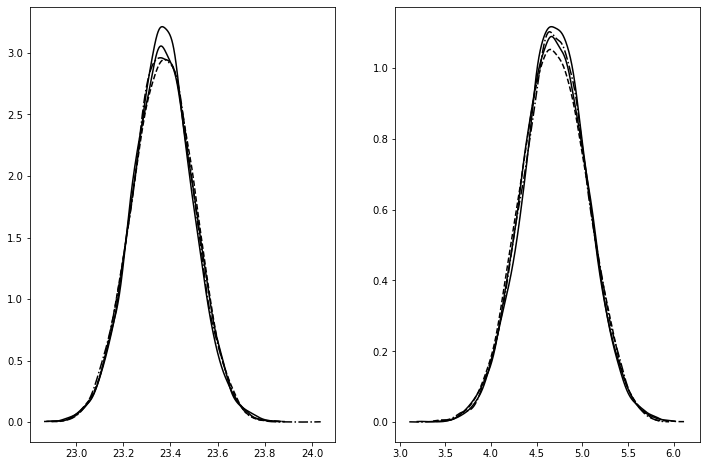

In [48]:
fig, ax = plt.subplots(1, 2, figsize = (12, 8))

# plotting the densities
ax[0].plot(a_c_range[0], a_c_density[0], "-k" , markersize = 3, label = "chain 1")
ax[0].plot(a_c_range[1], a_c_density[1], "--k", markersize = 3, label = "chain 2")
ax[0].plot(a_c_range[2], a_c_density[2], "-k" , markersize = 3, label = "chain 3")
ax[0].plot(a_c_range[3], a_c_density[3], "-.k", markersize = 3, label = "chain 4")

ax[1].plot(a_t_range[0], a_t_density[0], "-k" , markersize = 3, label = "chain 1")
ax[1].plot(a_t_range[1], a_t_density[1], "--k", markersize = 3, label = "chain 2")
ax[1].plot(a_t_range[2], a_t_density[2], "-k" , markersize = 3, label = "chain 3")
ax[1].plot(a_t_range[3], a_t_density[3], "-.k", markersize = 3, label = "chain 4")

# Setting the limit on the x axis
# ax[0].set_xlim(3550, 3850)
# ax[1].set_xlim(375, 575)


### Mean of the distribution of the second chain

In [49]:
chain = 2
predicted_a_c   = a_c_range[chain][numpy.where(a_c_density[chain] == a_c_density[chain].max())[0][0]]
predicted_a_t   = a_t_range[chain][numpy.where(a_t_density[chain] == a_t_density[chain].max())[0][0]]
predicted_alpha = alpha_range[chain][numpy.where(alpha_density[chain] == alpha_density[chain].max())[0][0]]
# predicted_sigma_ker = sigma_ker_range[chain][numpy.where(sigma_ker_density[chain] == sigma_ker_density[chain].max())[0][0]]
print(predicted_a_c, predicted_alpha, predicted_a_t)
# print(predicted_a_c, predicted_alpha)

23.360149677839228 -0.873615921956949 4.66206532702365


### Median of the distributions of the second chain

In [53]:
chain = 2
predicted_a_c   = numpy.median(a_c_range[chain])
predicted_a_t   = numpy.median(a_t_range[chain])
predicted_alpha = numpy.median(alpha_range[chain])
# predicted_sigma_ker = sigma_ker_range[chain][numpy.where(sigma_ker_density[chain] == sigma_ker_density[chain].max())[0][0]]
print(predicted_a_c, predicted_alpha, predicted_a_t)
# print(predicted_a_c, predicted_alpha)
             

23.32165193454749 -0.8740557534265715 5.0181506062202255


## Visualising the fit

In [50]:
def mg_model(wavelength, iron_value, parameter_array):
    a_c   = parameter_array[0]
    alpha = parameter_array[1]
    a_t   = parameter_array[2]
    sigma = parameter_array[3]
    
    kernel     = gaussian_filter(iron_value, sigma = sigma, mode = "nearest")
    
    continuum  = a_c * (wavelength/2599.) ** (alpha)
    
    iron       = a_t * kernel

    y_model    = continuum + iron
    
    return y_model, continuum, iron

In [51]:
predicted_data = [predicted_a_c, predicted_alpha, predicted_a_t, 25.] # 33.76

predicted_flux, pre_contin, pre_iron = mg_model(binned_spec_lambda, binned_iron_flux, predicted_data)

## two different visualisaitons of the flux using two different FeII broadening values

(1450.0, 3500.0)

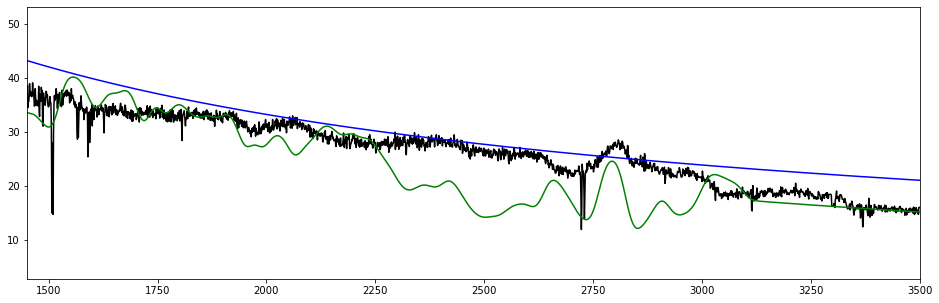

In [60]:
f, ax = plt.subplots(figsize = (16, 5))

ax.plot(binned_spec_lambda, binned_spec_flux_de, "-k")
ax.plot(binned_spec_lambda, predicted_flux, "-g")
ax.plot(binned_spec_lambda, pre_contin, "-b")
# ax.plot(binned_spec_lambda, pre_iron, "-m")
ax.set_xlim(1450, 3500)

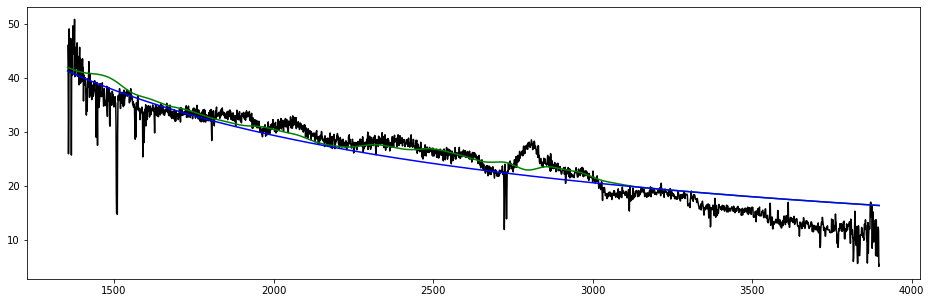

In [58]:
f, ax = plt.subplots(figsize = (16, 5))

ax.plot(binned_spec_lambda, binned_spec_flux_de, "-k")
ax.plot(binned_spec_lambda, predicted_flux, "-g")
ax.plot(binned_spec_lambda, pre_contin, "-b")
# ax.plot(binned_spec_lambda, pre_iron, "-m")
# ax.set_xlim(1450, 3500)

### Converting the flux to luminosity
I am not sure about the values that I used for the conversion but it seems that I have managed to reach similar orders of magnitudes in luminosity as fig. 1 of [K. Hryniewicz et al. 2010](https://academic.oup.com/mnras/article/404/4/2028/1087097).

(1450.0, 3400.0)

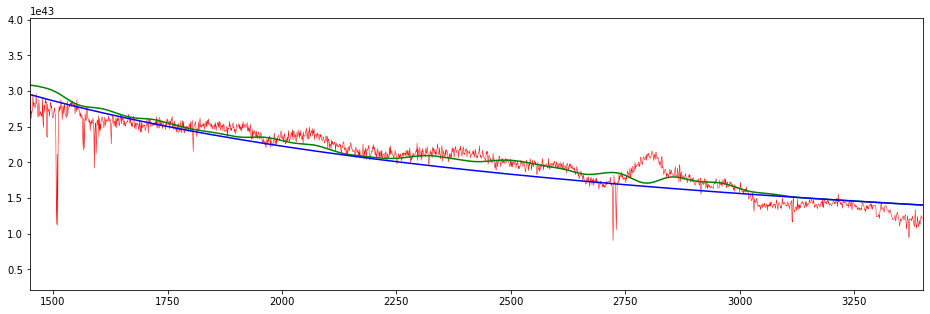

In [112]:
f, ax = plt.subplots(figsize = (16, 5))

binned_spec_lum_de   = binned_spec_flux_de  * 10**(-17) 
binned_spec_lumin_de = binned_spec_lum_de * (4 * numpy.pi * 1.32 * 10**28 * 1.66)**2 

predicted_lum        = predicted_flux  * 10**(-17) 
predicted_lumin      = predicted_lum * (4 * numpy.pi * 1.32 * 10**28 * 1.66)**2 

pre_contin_lum       = pre_contin  * 10**(-17)
pre_contin_lumin     = pre_contin_lum * (4 * numpy.pi * 1.32 * 10**28 * 1.66)**2 

ax.plot(binned_spec_lambda, binned_spec_lumin_de, "-r", linewidth = 0.5)
ax.plot(binned_spec_lambda, predicted_lumin, "-g")
ax.plot(binned_spec_lambda, pre_contin_lumin, "-b")
# ax.plot(binned_spec_lambda, pre_iron, "-m")
ax.set_xlim(1450, 3400)

### Conclusion

- Given the fit results above it seems that I'm on the right track. According to section 2.1. of the paper [K. Hryniewicz et al. 2010](https://academic.oup.com/mnras/article/404/4/2028/1087097) their process of fitting is an iteritive process. This means that I need to subtract the predicted continuum from the quasars spectrum and then subtract the predicted Fe II template from the quasar spectrum and repeat the subtraction process a few more times until we reach the best fit. I will work on this later!

### Just a quick test of broadening Fe II template using different sigma values

In [63]:
smoothed1 = gaussian_filter(binned_iron_flux, sigma = 5, mode = "nearest")
smoothed2 = gaussian_filter(binned_iron_flux, sigma = 40, mode = "nearest")
smoothed3 = gaussian_filter(binned_iron_flux, sigma = 45, mode = "nearest")
smoothed4 = gaussian_filter(binned_iron_flux, sigma = 50, mode = "nearest")
smoothed5 = gaussian_filter(binned_iron_flux, sigma = 55, mode = "nearest")
smoothed6 = gaussian_filter(binned_iron_flux, sigma = 30, mode = "nearest")
smoothed7 = gaussian_filter(binned_iron_flux, sigma = 15, mode = "nearest")


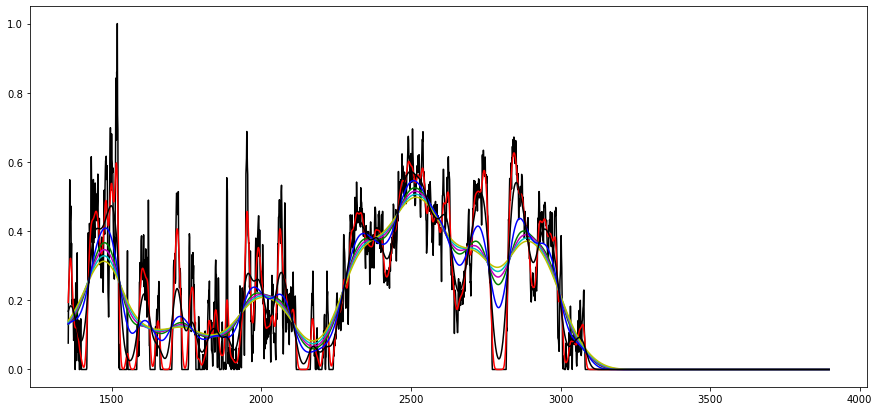

In [111]:
f, ax = plt.subplots(figsize = (15, 7))

# ax.plot(binned_spec_lambda, binned_spec_flux/20, "-k")
ax.plot(binned_spec_lambda, binned_iron_flux, "-k")
ax.plot(binned_spec_lambda, smoothed1, "-r")
ax.plot(binned_spec_lambda, smoothed2, "-g")
ax.plot(binned_spec_lambda, smoothed3, "-m")
ax.plot(binned_spec_lambda, smoothed4, "-c")
ax.plot(binned_spec_lambda, smoothed5, "-y")
ax.plot(binned_spec_lambda, smoothed6, "-b")
ax.plot(binned_spec_lambda, smoothed7, "-k")

# ax.set_xlim(2200, 3100)